# Final Project: San Francisco Bike Theft Predictions

# Part 1: Proposal
*Frame the problem, criteria, and data source(s)*

## Problem Statement

1. Hypothesis/assumptions
2. Goals and Success Metrics
3. Risk/Limitations
4. Data Source

## Data Sources 

**Stolen and not stolen bike data from the [Bikeindex API3](https://bikeindex.org/documentation/api_v3).**
- Data collected real time. 
- API scraped as of November 5, 2018.

**Income data by Zipcode from the [IRS website](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)**
- 2016 tax return data

**Demographic and Housing data from [American Community Service DP05 - American Factfinder](https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml)**
- 2016 5 year estmates DP05
- Used Percentages

**Census Population data from the [Decennial Census - American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml)**
- 2010 Census

**San Francisco City data from the [datasf.org](https://data.sfgov.org/City-Management-and-Ethics/San-Francisco-City-Survey-Data-1996-2017/huch-6k5m).**
- Data collected every two years. 
- Documentation recommends using data from 2015 forward.
- Most complete zipcode-related data is from 2017 survey.

For this project, I downloaded all the bike data in BikeIndex and merged California demographic data via zipcodes. The following lines of code document my method of cleaning the bike data and combining it with IRS, ACS, and Census data in a meaningful way. I will be standardizing stolen data to create a stolen rate per zipcode.

Bike retrieval code can be found at my [github here](https://github.com/chanwinyee/ds_foundations/blob/master/final_project/bike_index_data_retrieval_DONE.ipynb).


### Assumptions:

**Assumption 1:** Knowing that my demographic data covers a span of 2010 - 2016, I will be generalizing those metrics to BikeIndex information from 2010 to 2018.

**Assumption 2:** I am using demographic data of areas proportioned by zipcodes to predict a theft rate. These zipcodes are a blend of borders defined by the 2010 census and 2016 IRS and ACS surveys.

### Limitations

**Limitation 1:** I only have location data for bikes that have been stolen. 
- I standardized bike theft into a stolen rate by taking the sume of thefts from 2010 - 2018 and dividing it by the total population of the zipcode. 
- I am utilizing the Plugin Principle to generalize the trends from this dataset of samples (zipcode = sample) to all of California.

**Limitation 2:** Demographic data could not be found in all zipcodes and do not come from the same data source. 
- I stitched demographic data from 2010 and 2016




In [1]:
# Data cleaning, exploration, and analysis tools
import pandas as pd
import seaborn as sns
import numpy as np
from ast import literal_eval
import re as re
from matplotlib import pyplot
import scipy.stats as stats
%matplotlib inline

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')


### Clean the BikeIndex data

In [2]:
# Import the csv of stolen and not stolen bike data and store in a pandas DataFrame
bike_data = pd.read_csv('bike_index_api_stolenessall.csv')
bike_df = pd.DataFrame(data=bike_data)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188574 entries, 0 to 188573
Data columns (total 14 columns):
Unnamed: 0           188574 non-null int64
date_stolen          62097 non-null float64
frame_colors         188574 non-null object
frame_model          170000 non-null object
id                   188574 non-null int64
is_stock_img         188574 non-null bool
large_img            78875 non-null object
manufacturer_name    188567 non-null object
serial               188211 non-null object
stolen               188574 non-null bool
stolen_location      61129 non-null object
thumb                78875 non-null object
title                188573 non-null object
year                 133836 non-null float64
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 17.6+ MB


In [3]:
bike_df.head()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year
0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN
1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN
2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN
3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0
4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0


This bike data has all datapoints ever collected in the BikeIndex API. What I really want are datapoints for bikes that are in California.


In [4]:
bike_df_clean = bike_df.copy()
bike_df_clean = bike_df_clean[bike_df_clean['stolen_location'].apply(str).str.contains('CA|California')]

In [5]:
# Confirm that there are both stolen and non-stolen datapoints
bike_df_clean['stolen'].value_counts()

True     12027
False        3
Name: stolen, dtype: int64

In [6]:

def split_zipcode(x):
    array=re.findall('\d{5}',str(x))
    if len(array)==0:
        return None
    else:
        return array[0]
            
bike_df_clean['stolen_zipcode'] = bike_df_clean['stolen_location'].apply(split_zipcode)

In [7]:
# Confirm that the zipcode dad has been successfully parsed out into a new column
bike_df_clean.head()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode
33,33,1.541264e+09,['Blue'],Cross-Check,462239,False,https://files.bikeindex.org/uploads/Pu/140320/...,Surly,YS-PC20270,True,"San Francisco,CA,94105",https://files.bikeindex.org/uploads/Pu/140320/...,2014 Surly Cross-Check,2014.0,94105
39,39,1.541236e+09,"['Red', 'Silver, gray or bare metal']",OCR 3,461486,False,https://files.bikeindex.org/uploads/Pu/140180/...,Giant,absent,True,"San Francisco,CA,94114",https://files.bikeindex.org/uploads/Pu/140180/...,2007 Giant OCR 3,2007.0,94114
40,40,1.541236e+09,"['Silver, gray or bare metal']",Thin 7,461723,False,https://files.bikeindex.org/uploads/Pu/140253/...,Sondors,MT17004959,True,"Berkeley,CA,94704",https://files.bikeindex.org/uploads/Pu/140253/...,Sondors Thin 7,NaN,94704
41,41,1.541221e+09,['Black'],N/a,461764,False,https://files.bikeindex.org/uploads/Pu/140264/...,Not visible on bike,absent,True,"San Francisco,CA,94110",https://files.bikeindex.org/uploads/Pu/140264/...,Not visible on bike N/a,NaN,94110
42,42,1.541259e+09,['White'],Lightweight 6061 Aluminum Frame,460962,False,NaN,SXL,absent,True,"Los Angeles,CA,90007",NaN,2018 SXL Lightweight 6061 Aluminum Frame,2018.0,90007


In [8]:
# The size of the California dataset is much smaller than the original dataset
bike_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12030 entries, 33 to 99992
Data columns (total 15 columns):
Unnamed: 0           12030 non-null int64
date_stolen          12030 non-null float64
frame_colors         12030 non-null object
frame_model          11125 non-null object
id                   12030 non-null int64
is_stock_img         12030 non-null bool
large_img            7180 non-null object
manufacturer_name    12030 non-null object
serial               12002 non-null object
stolen               12030 non-null bool
stolen_location      12030 non-null object
thumb                7180 non-null object
title                12030 non-null object
year                 9971 non-null float64
stolen_zipcode       11683 non-null object
dtypes: bool(2), float64(2), int64(2), object(9)
memory usage: 1.3+ MB


In [9]:
# Convert the date_stolen into something readable and extract the year
bike_df_clean['date_stolen'] = pd.to_datetime(bike_df_clean['date_stolen'],unit='s')
bike_df_clean['year_stolen'] = bike_df_clean['date_stolen'].dt.year

In [10]:
# Confirm that the year has been extracted correctly.
bike_df_clean

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode,year_stolen
33,33,2018-11-03 17:00:00,['Blue'],Cross-Check,462239,False,https://files.bikeindex.org/uploads/Pu/140320/...,Surly,YS-PC20270,True,"San Francisco,CA,94105",https://files.bikeindex.org/uploads/Pu/140320/...,2014 Surly Cross-Check,2014.0,94105,2018
39,39,2018-11-03 09:00:00,"['Red', 'Silver, gray or bare metal']",OCR 3,461486,False,https://files.bikeindex.org/uploads/Pu/140180/...,Giant,absent,True,"San Francisco,CA,94114",https://files.bikeindex.org/uploads/Pu/140180/...,2007 Giant OCR 3,2007.0,94114,2018
40,40,2018-11-03 09:00:00,"['Silver, gray or bare metal']",Thin 7,461723,False,https://files.bikeindex.org/uploads/Pu/140253/...,Sondors,MT17004959,True,"Berkeley,CA,94704",https://files.bikeindex.org/uploads/Pu/140253/...,Sondors Thin 7,NaN,94704,2018
41,41,2018-11-03 05:00:00,['Black'],N/a,461764,False,https://files.bikeindex.org/uploads/Pu/140264/...,Not visible on bike,absent,True,"San Francisco,CA,94110",https://files.bikeindex.org/uploads/Pu/140264/...,Not visible on bike N/a,NaN,94110,2018
42,42,2018-11-03 15:24:15,['White'],Lightweight 6061 Aluminum Frame,460962,False,NaN,SXL,absent,True,"Los Angeles,CA,90007",NaN,2018 SXL Lightweight 6061 Aluminum Frame,2018.0,90007,2018
47,47,2018-11-02 23:00:00,"['Silver, gray or bare metal']",Mountain,462623,False,NaN,Genesis,no number,True,"Chico,CA,95973",NaN,Genesis Mountain,NaN,95973,2018
48,48,2018-11-02 21:00:44,"['Silver, gray or bare metal']",Cadent 1,460772,False,https://files.bikeindex.org/uploads/Pu/140095/...,Raleigh,u149k14722,True,"San Francisco,CA,94103",https://files.bikeindex.org/uploads/Pu/140095/...,2015 Raleigh Cadent 1,2015.0,94103,2018
49,49,2018-11-02 21:00:00,"['Silver, gray or bare metal']",Bike DB APEX,460776,False,https://files.bikeindex.org/uploads/Pu/140096/...,Diamondback,DAA16F000473,True,"San Diego,CA,92109",https://files.bikeindex.org/uploads/Pu/140096/...,2016 Diamondback Bike DB APEX,2016.0,92109,2018
56,56,2018-11-02 18:56:45,"['Blue', 'Blue']","19"" frame size kent bayside.",460699,False,NaN,Kent,GS72696,True,"Santa Ana,CA,92705",NaN,"Kent 19"" frame size kent bayside.",NaN,92705,2018
69,69,2018-11-02 04:00:00,['Black'],Volare,69412,False,https://files.bikeindex.org/uploads/Pu/46648/l...,Schwinn,SNMNG 14C37721,True,"San Francisco,CA,94118",https://files.bikeindex.org/uploads/Pu/46648/s...,2014 Schwinn Volare,2014.0,94118,2018


In [11]:
# Check to see if the data is clean for year, as in, there are no repeat years or strange ways to notate the year
year_stolen = []
year_stolen = bike_df_clean['year_stolen'].unique()
year_stolen.sort()
year_stolen

array([1990, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

**Assumption 1:** Knowing that my demographic data covers a span of 2010 - 2016, I will be generalizing those metrics to BikeIndex information from 2010 to 2018.

In [12]:
bike_df_clean.groupby('year_stolen').count()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode
year_stolen,,,,,,,,,,,,,,,
1990,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1998,6,6,6,6,6,6,0,6,6,6,6,0,6,6,6
2000,20,20,20,17,20,20,3,20,20,20,20,3,20,18,20
2001,1,1,1,0,1,1,0,1,1,1,1,0,1,0,1
2002,5,5,5,5,5,5,0,5,5,5,5,0,5,4,5
2003,2,2,2,2,2,2,0,2,2,2,2,0,2,2,2
2004,10,10,10,10,10,10,0,10,10,10,10,0,10,8,10
2005,108,108,108,103,108,108,15,108,108,108,108,15,108,96,108
2006,149,149,149,145,149,149,14,149,149,149,149,14,149,136,149


In [13]:
# Select data from year_stolen 2010 to 2018
bike_df_final = bike_df_clean[bike_df_clean['year_stolen']>2009]

bike_df_final['year_stolen'].unique()

array([2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010])

In [14]:
bike_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10766 entries, 33 to 99992
Data columns (total 16 columns):
Unnamed: 0           10766 non-null int64
date_stolen          10766 non-null datetime64[ns]
frame_colors         10766 non-null object
frame_model          9920 non-null object
id                   10766 non-null int64
is_stock_img         10766 non-null bool
large_img            6767 non-null object
manufacturer_name    10766 non-null object
serial               10738 non-null object
stolen               10766 non-null bool
stolen_location      10766 non-null object
thumb                6767 non-null object
title                10766 non-null object
year                 8889 non-null float64
stolen_zipcode       10420 non-null object
year_stolen          10766 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(9)
memory usage: 1.3+ MB


In [15]:
# Store final data into csv
bike_df_final.to_csv(path_or_buf='/Users/lizchan/ds_foundations/final_project/bike_data_clean.csv')

## Clean and combine demographics data

**Assumption 2:** I am using demographic data of areas proportioned by zipcodes to predict a theft rate. These zipcodes are a blend of borders defined by the 2010 census and 2016 IRS and ACS surveys.

### Income Data from the IRS Website

In [16]:
#Import the Tax Data

income_data = pd.read_excel('tax_data.xls')

In [17]:
active_columns=['Zipcode','Size of adjusted gross income','Number of returns']
income_data = income_data[active_columns]

In [18]:
income_data.head()

,Zipcode,Size of adjusted gross income,Number of returns
0,0,Total,17532400.0
1,0,"$1 under $25,000",5975570.0
2,0,"$25,000 under $50,000",4168180.0
3,0,"$50,000 under $75,000",2328820.0
4,0,"$75,000 under $100,000",1496930.0


In [19]:
# Clean the zipcode column

income_data.groupby('Zipcode').sum()

def split_zipcode(x):
    array=re.findall('^\d{5}',str(x))
    if len(array)==0:
        return None
    else:
        return array[0]
            
income_data['zipcode_clean'] = income_data['Zipcode'].apply(split_zipcode)
income_clean = income_data.dropna()

In [20]:
income_clean.head()

,Zipcode,Size of adjusted gross income,Number of returns,zipcode_clean
9,90001,"$1 under $25,000",11890.0,90001
10,90001,"$25,000 under $50,000",7020.0,90001
11,90001,"$50,000 under $75,000",1940.0,90001
12,90001,"$75,000 under $100,000",560.0,90001
13,90001,"$100,000 under $200,000",240.0,90001


In [21]:
# Create a data dictionary to convert the adjusted gross income into a contiguous value

income_cont = {
    '$1 under $25,000':25000,
    '$25,000 under $50,000':50000,
    '$50,000 under $75,000':75000,
    '$75,000 under $100,000':100000,
    '$100,000 under $200,000':200000,
    '$200,000 or more':300000
}

In [22]:
# replace strings with contiguous values
income_clean['income'] = income_clean['Size of adjusted gross income'].map(income_cont)

In [23]:
income_clean.head()

,Zipcode,Size of adjusted gross income,Number of returns,zipcode_clean,income
9,90001,"$1 under $25,000",11890.0,90001,25000
10,90001,"$25,000 under $50,000",7020.0,90001,50000
11,90001,"$50,000 under $75,000",1940.0,90001,75000
12,90001,"$75,000 under $100,000",560.0,90001,100000
13,90001,"$100,000 under $200,000",240.0,90001,200000


In [24]:
#check datatypes for compatibility in aggregating income data
income_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8892 entries, 9 to 11862
Data columns (total 5 columns):
Zipcode                          8892 non-null object
Size of adjusted gross income    8892 non-null object
Number of returns                8892 non-null float64
zipcode_clean                    8892 non-null object
income                           8892 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 416.8+ KB


In [25]:
income_clean[['Number of returns', 'income']] = income_clean[['Number of returns', 'income']].astype(float)
income_clean['income_total']=income_clean['Number of returns']*income_clean['income']

In [26]:
income_clean.head()

,Zipcode,Size of adjusted gross income,Number of returns,zipcode_clean,income,income_total
9,90001,"$1 under $25,000",11890.0,90001,25000.0,297250000.0
10,90001,"$25,000 under $50,000",7020.0,90001,50000.0,351000000.0
11,90001,"$50,000 under $75,000",1940.0,90001,75000.0,145500000.0
12,90001,"$75,000 under $100,000",560.0,90001,100000.0,56000000.0
13,90001,"$100,000 under $200,000",240.0,90001,200000.0,48000000.0


In [27]:
zipcodeincome_df = income_clean.copy()
zipcodeincome_df=zipcodeincome_df.groupby('zipcode_clean').sum()

In [28]:
zipcodeincome_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1482 entries, 90001 to 99999
Data columns (total 3 columns):
Number of returns    1482 non-null float64
income               1482 non-null float64
income_total         1482 non-null float64
dtypes: float64(3)
memory usage: 46.3+ KB


In [29]:
# Calculate the average income per zipcode
zipcodeincome_df['avg_income']=zipcodeincome_df['income_total']/zipcodeincome_df['Number of returns']

In [30]:
# extrapolate the relevant columns
final_columns = ['avg_income']
final_income = zipcodeincome_df[final_columns]
income_2016=final_income

In [31]:
income_2016.head()

,avg_income
zipcode_clean,
90001,41705.122289
90002,41365.007541
90003,39803.957494
90004,64724.919094
90005,55977.917981


### Race and ethnicity data from the American Community Service survey

In [32]:
acs_raw = pd.read_csv('ACS_16_5YR_DP05_with_ann.csv')

In [33]:
acs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33121 entries, 0 to 33120
Columns: 339 entries, GEO.id to HC04_VC110
dtypes: object(339)
memory usage: 85.7+ MB


In [34]:
acs_raw.columns

Index(['GEO.id', 'GEO.id2', 'GEO.display-label', 'HC01_VC03', 'HC02_VC03',
       'HC03_VC03', 'HC04_VC03', 'HC01_VC04', 'HC02_VC04', 'HC03_VC04',
       ...
       'HC03_VC108', 'HC04_VC108', 'HC01_VC109', 'HC02_VC109', 'HC03_VC109',
       'HC04_VC109', 'HC01_VC110', 'HC02_VC110', 'HC03_VC110', 'HC04_VC110'],
      dtype='object', length=339)

In [35]:
# Only use columns that aggregate percents (and drop columns related to margin of error or estimates)
active_columns = [col for col in acs_raw.columns if col.startswith('HC03')]
active_columns.append('GEO.display-label')
acs_raw=acs_raw[active_columns]

In [36]:
acs_raw.head()

,HC03_VC03,HC03_VC04,HC03_VC05,HC03_VC08,HC03_VC09,HC03_VC10,HC03_VC11,HC03_VC12,HC03_VC13,HC03_VC14,...,HC03_VC98,HC03_VC99,HC03_VC100,HC03_VC101,HC03_VC102,HC03_VC104,HC03_VC108,HC03_VC109,HC03_VC110,GEO.display-label
0,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,Percent; SEX AND AGE - 35 to 44 years,...,Percent; HISPANIC OR LATINO AND RACE - Total p...,Percent; HISPANIC OR LATINO AND RACE - Total p...,Percent; HISPANIC OR LATINO AND RACE - Total p...,Percent; HISPANIC OR LATINO AND RACE - Total p...,Percent; HISPANIC OR LATINO AND RACE - Total p...,Percent; HISPANIC OR LATINO AND RACE - Total h...,"Percent; CITIZEN, VOTING AGE POPULATION - Citi...","Percent; CITIZEN, VOTING AGE POPULATION - Citi...","Percent; CITIZEN, VOTING AGE POPULATION - Citi...",Geography
1,17800,48.9,51.1,5.3,6.1,7.4,7.3,7.2,12.5,11.7,...,0.0,0.0,0.0,0.0,0.0,(X),13646,48.2,51.8,ZCTA5 00601
2,39716,49.1,50.9,4.8,6.2,5.5,7.1,7.0,12.6,12.7,...,0.0,0.1,2.4,0.1,2.3,(X),31048,48.8,51.2,ZCTA5 00602
3,51565,48.9,51.1,4.9,6.1,6.2,7.0,6.7,12.3,12.9,...,0.0,0.2,0.9,0.0,0.9,(X),40167,47.8,52.2,ZCTA5 00603
4,6320,49.6,50.4,5.2,4.5,6.3,7.4,7.2,10.4,12.8,...,0.0,0.0,0.0,0.0,0.0,(X),5007,48.4,51.6,ZCTA5 00606


In [37]:
# Re set the column names and drop the old row
acs_raw.columns = acs_raw.iloc[0]
acs_raw = acs_raw.reindex(acs_raw.index.drop(0))

In [38]:
acs_raw.head()

,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,Percent; SEX AND AGE - 35 to 44 years,...,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races including Some other race,"Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races excluding Some other race, and Three or more races",Percent; HISPANIC OR LATINO AND RACE - Total housing units,"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",Geography
1,17800,48.9,51.1,5.3,6.1,7.4,7.3,7.2,12.5,11.7,...,0.0,0.0,0.0,0.0,0.0,(X),13646,48.2,51.8,ZCTA5 00601
2,39716,49.1,50.9,4.8,6.2,5.5,7.1,7.0,12.6,12.7,...,0.0,0.1,2.4,0.1,2.3,(X),31048,48.8,51.2,ZCTA5 00602
3,51565,48.9,51.1,4.9,6.1,6.2,7.0,6.7,12.3,12.9,...,0.0,0.2,0.9,0.0,0.9,(X),40167,47.8,52.2,ZCTA5 00603
4,6320,49.6,50.4,5.2,4.5,6.3,7.4,7.2,10.4,12.8,...,0.0,0.0,0.0,0.0,0.0,(X),5007,48.4,51.6,ZCTA5 00606
5,27976,48.4,51.6,4.8,4.9,7.2,7.3,7.1,11.7,13.1,...,0.0,0.1,0.4,0.0,0.4,(X),21981,47.4,52.6,ZCTA5 00610


In [39]:
# Clean the zipcode column

def split_zipcode(x):
    array=re.findall('\d{5}',str(x))
    if len(array)==0:
        return None
    else:
        return array[0]
            
acs_raw['zipcode_clean'] = acs_raw['Geography'].apply(split_zipcode)

In [40]:
acs_2016=acs_raw.drop(columns='Geography')

In [41]:
acs_2016.head()

,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,Percent; SEX AND AGE - 35 to 44 years,...,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races including Some other race,"Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races excluding Some other race, and Three or more races",Percent; HISPANIC OR LATINO AND RACE - Total housing units,"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",zipcode_clean
1,17800,48.9,51.1,5.3,6.1,7.4,7.3,7.2,12.5,11.7,...,0.0,0.0,0.0,0.0,0.0,(X),13646,48.2,51.8,00601
2,39716,49.1,50.9,4.8,6.2,5.5,7.1,7.0,12.6,12.7,...,0.0,0.1,2.4,0.1,2.3,(X),31048,48.8,51.2,00602
3,51565,48.9,51.1,4.9,6.1,6.2,7.0,6.7,12.3,12.9,...,0.0,0.2,0.9,0.0,0.9,(X),40167,47.8,52.2,00603
4,6320,49.6,50.4,5.2,4.5,6.3,7.4,7.2,10.4,12.8,...,0.0,0.0,0.0,0.0,0.0,(X),5007,48.4,51.6,00606
5,27976,48.4,51.6,4.8,4.9,7.2,7.3,7.1,11.7,13.1,...,0.0,0.1,0.4,0.0,0.4,(X),21981,47.4,52.6,00610


### Population Data from the US Census 2010

In [42]:
census_2010 = pd.read_csv('DEC_10_SF1_P1_with_ann.csv')

In [43]:
census_2010.head()

,GEO.id,GEO.id2,GEO.display-label,D001
0,Id,Id2,Geography,Total
1,8600000US00601,00601,ZCTA5 00601,18570
2,8600000US00602,00602,ZCTA5 00602,41520
3,8600000US00603,00603,ZCTA5 00603,54689
4,8600000US00606,00606,ZCTA5 00606,6615


In [44]:
# Reset the column headers
census_2010.columns = census_2010.iloc[0]
census_2010 = census_2010.reindex(census_2010.index.drop(0))

In [45]:
# Clean the zipcode column

def split_zipcode(x):
    array=re.findall('\d{5}',str(x))
    if len(array)==0:
        return None
    else:
        return array[0]
            
# Clean the other column names
census_2010['zipcode'] = census_2010['Geography'].apply(split_zipcode)
census_2010['total_population'] = census_2010['Total']
active_columns=['zipcode','total_population']
census_2010=census_2010[active_columns]

In [46]:
census_2010.head()

,zipcode,total_population
1,00601,18570
2,00602,41520
3,00603,54689
4,00606,6615
5,00610,29016


### Merge the demographics data all together

In [47]:
demographics_rough = pd.merge(acs_2016, income_2016,how='left', right_on = 'zipcode_clean', left_on = 'zipcode_clean')
demographics = pd.merge(demographics_rough, census_2010,how='left', left_on = 'zipcode_clean', right_on = 'zipcode')


In [48]:
#drop any incomplete samples

demographics_clean = demographics.copy()
demographics_clean=demographics.dropna()
demographics_clean = demographics_clean.drop(columns=['zipcode_clean','Total Population','Total Males','Total Females'])

In [49]:
demographics_clean.head()

,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,Percent; SEX AND AGE - 35 to 44 years,...,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races including Some other race,"Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races excluding Some other race, and Three or more races",Percent; HISPANIC OR LATINO AND RACE - Total housing units,"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",avg_income,zipcode,total_population
30010,57942,50.9,49.1,8.9,9.3,8.5,9.1,9.0,15.6,13.5,...,0.2,0.0,0.1,(X),22826,48.2,51.8,41705.122289,90001,57110
30011,51826,48.0,52.0,9.0,8.6,9.0,9.5,9.4,14.5,13.9,...,0.4,0.0,0.4,(X),22428,46.1,53.9,41365.007541,90002,51223
30012,70208,48.4,51.6,9.6,9.3,9.0,9.2,8.4,15.1,13.5,...,0.3,0.0,0.3,(X),27958,44.3,55.7,39803.957494,90003,66266
30013,63095,49.4,50.6,6.1,5.2,5.4,5.3,6.9,19.9,15.5,...,2.1,0.2,1.9,(X),32688,50.3,49.7,64724.919094,90004,62180
30014,39338,49.8,50.2,6.9,5.5,5.0,4.4,7.1,22.7,16.2,...,1.3,0.1,1.2,(X),15980,47.6,52.4,55977.917981,90005,37681


In [50]:
demographics_clean.to_csv(path_or_buf='/Users/lizchan/ds_foundations/final_project/demographics_data_clean.csv')

# Part 2: Brief
*Perform EDA on the dataset*

## Exploratory Data Summary
1. Create an exploratory data analysis notebook.
2. Perform statistical analysis, along with any visualizations.
3. Determine how to handle sampling or missing values.
4. Clearly identify shortcomings, assumptions, and next steps.


## Merge Demographics data and Bike Data

In [51]:
demographics_df = pd.read_csv('demographics_data_clean.csv')

In [52]:
bike_df = pd.read_csv('bike_data_clean.csv')

In [53]:
# Clean the bike dataframe to only have stolen information aggregated by zipcode

active_columns = ['stolen','stolen_zipcode']
bike_df = bike_df[active_columns]
bike_df = bike_df.groupby('stolen_zipcode').count()
bike_df = bike_df.sort_values(by='stolen', ascending=False)
bike_df['total_stolen'] = bike_df['stolen']
bike_df = bike_df.drop(columns='stolen')
bike_df.head()


,total_stolen
stolen_zipcode,
94110.0,475
94103.0,407
94114.0,221
94117.0,220
94107.0,202


Interesting observation - Since 2010, the cities with the most bike theft in this dataset are in San Francisco:
- 94110 --> Cesar Chavez and Mission Street, San Francisco, CA
- 94103 --> 10th and Harisson, San Francisco, CA
- 94114 --> Dolores Heights, 20th and Castro Street, San Francisco, CA
- 94117 --> the Pandhandle, Fell St. and Masonic Ave, San Francisco, CA
- 94108 --> Potrero Hill, Mariposa St. and Arkansas, San Francisco, CA


In [54]:
# Merge datasets on stolen_zipcode == zipcode; drop bikes stolen that do not have zipcode
bikedata_df = pd.merge(bike_df, demographics_df,how='left', right_on = 'zipcode', left_on = 'stolen_zipcode')
bikedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 89 columns):
total_stolen                                                                                                                                                           961 non-null int64
Unnamed: 0                                                                                                                                                             822 non-null float64
Percent; SEX AND AGE - Total population                                                                                                                                822 non-null float64
Percent; SEX AND AGE - Total population - Male                                                                                                                         822 non-null object
Percent; SEX AND AGE - Total population - Female                                                                                                  

In [55]:
# Clean Dataset of irrelevant columns and nulls
bikedata_df=bikedata_df.drop(columns='Unnamed: 0')
bikedata_df=bikedata_df.dropna()
bikedata_df.head()

,total_stolen,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,...,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races including Some other race,"Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races excluding Some other race, and Three or more races",Percent; HISPANIC OR LATINO AND RACE - Total housing units,"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",avg_income,zipcode,total_population
0,475,73511.0,53.7,46.3,5.5,4.2,2.9,2.6,5.3,25.4,...,3.9,0.2,3.8,(X),50817.0,53.9,46.1,113625.225690,94110.0,69333.0
1,407,25747.0,58.8,41.2,2.4,2.4,2.4,1.8,5.4,25.7,...,4.7,0.2,4.5,(X),19506.0,60.4,39.6,112264.447236,94103.0,27170.0
2,221,33504.0,58.9,41.1,5.3,3.0,1.9,1.4,3.1,23.2,...,4.3,0.2,4.2,(X),27099.0,60.1,39.9,155402.750491,94114.0,31124.0
3,220,43323.0,52.6,47.4,3.9,2.7,1.5,6.5,5.4,31.7,...,4.6,0.1,4.5,(X),36455.0,52.9,47.1,134593.777010,94117.0,39169.0
4,202,29384.0,51.9,48.1,5.5,2.6,2.7,2.1,5.6,27.3,...,4.6,0.1,4.6,(X),21333.0,52.9,47.1,153975.623912,94107.0,26599.0


In [56]:
# Standardize stolen metric
bikedata_df['stolen_rate']=bikedata_df['total_stolen']/bikedata_df['total_population']
bikedata_df.head()

,total_stolen,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,...,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races including Some other race,"Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races excluding Some other race, and Three or more races",Percent; HISPANIC OR LATINO AND RACE - Total housing units,"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",avg_income,zipcode,total_population,stolen_rate
0,475,73511.0,53.7,46.3,5.5,4.2,2.9,2.6,5.3,25.4,...,0.2,3.8,(X),50817.0,53.9,46.1,113625.225690,94110.0,69333.0,0.006851
1,407,25747.0,58.8,41.2,2.4,2.4,2.4,1.8,5.4,25.7,...,0.2,4.5,(X),19506.0,60.4,39.6,112264.447236,94103.0,27170.0,0.014980
2,221,33504.0,58.9,41.1,5.3,3.0,1.9,1.4,3.1,23.2,...,0.2,4.2,(X),27099.0,60.1,39.9,155402.750491,94114.0,31124.0,0.007101
3,220,43323.0,52.6,47.4,3.9,2.7,1.5,6.5,5.4,31.7,...,0.1,4.5,(X),36455.0,52.9,47.1,134593.777010,94117.0,39169.0,0.005617
4,202,29384.0,51.9,48.1,5.5,2.6,2.7,2.1,5.6,27.3,...,0.1,4.6,(X),21333.0,52.9,47.1,153975.623912,94107.0,26599.0,0.007594


In [57]:
# Change the datatype of all appropriate columns to float. I know there are a lot of object/strings in there

mixed_columns = []
def change_type(dataframe):
    for col in dataframe.columns:
        try:
            dataframe[col]=dataframe[col].astype(float)
        except:
            pass
            mixed_columns.append(col)

change_type(bikedata_df)



In [58]:
bikedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 959
Data columns (total 89 columns):
total_stolen                                                                                                                                                           822 non-null float64
Percent; SEX AND AGE - Total population                                                                                                                                822 non-null float64
Percent; SEX AND AGE - Total population - Male                                                                                                                         822 non-null float64
Percent; SEX AND AGE - Total population - Female                                                                                                                       822 non-null float64
Percent; SEX AND AGE - Under 5 years                                                                                                           

In [59]:
# Examine and clean the columns that do not have numeric values
mixed_columns

['Percent; SEX AND AGE - Median age (years)',
 'Percent; HISPANIC OR LATINO AND RACE - Total housing units']

In [60]:
bikedata_df['Percent; SEX AND AGE - Median age (years)'].unique()

array(['(X)'], dtype=object)

In [61]:
bikedata_df['Percent; HISPANIC OR LATINO AND RACE - Total housing units'].unique()

array(['(X)'], dtype=object)

It seems that there is no data on median age in years and Percent; HISPANIC OR LATINO AND RACE - Total housing units as a percent. I will discard these columns

In [62]:
bikedata_df = bikedata_df.drop(columns=mixed_columns)

In [63]:
# Reassign zipcode as a string since this is a classifier

bikedata_df['zipcode']=bikedata_df['zipcode'].astype(int)
bikedata_df['zipcode']=bikedata_df['zipcode'].astype(str)
bikedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 959
Data columns (total 87 columns):
total_stolen                                                                                                                                                           822 non-null float64
Percent; SEX AND AGE - Total population                                                                                                                                822 non-null float64
Percent; SEX AND AGE - Total population - Male                                                                                                                         822 non-null float64
Percent; SEX AND AGE - Total population - Female                                                                                                                       822 non-null float64
Percent; SEX AND AGE - Under 5 years                                                                                                           

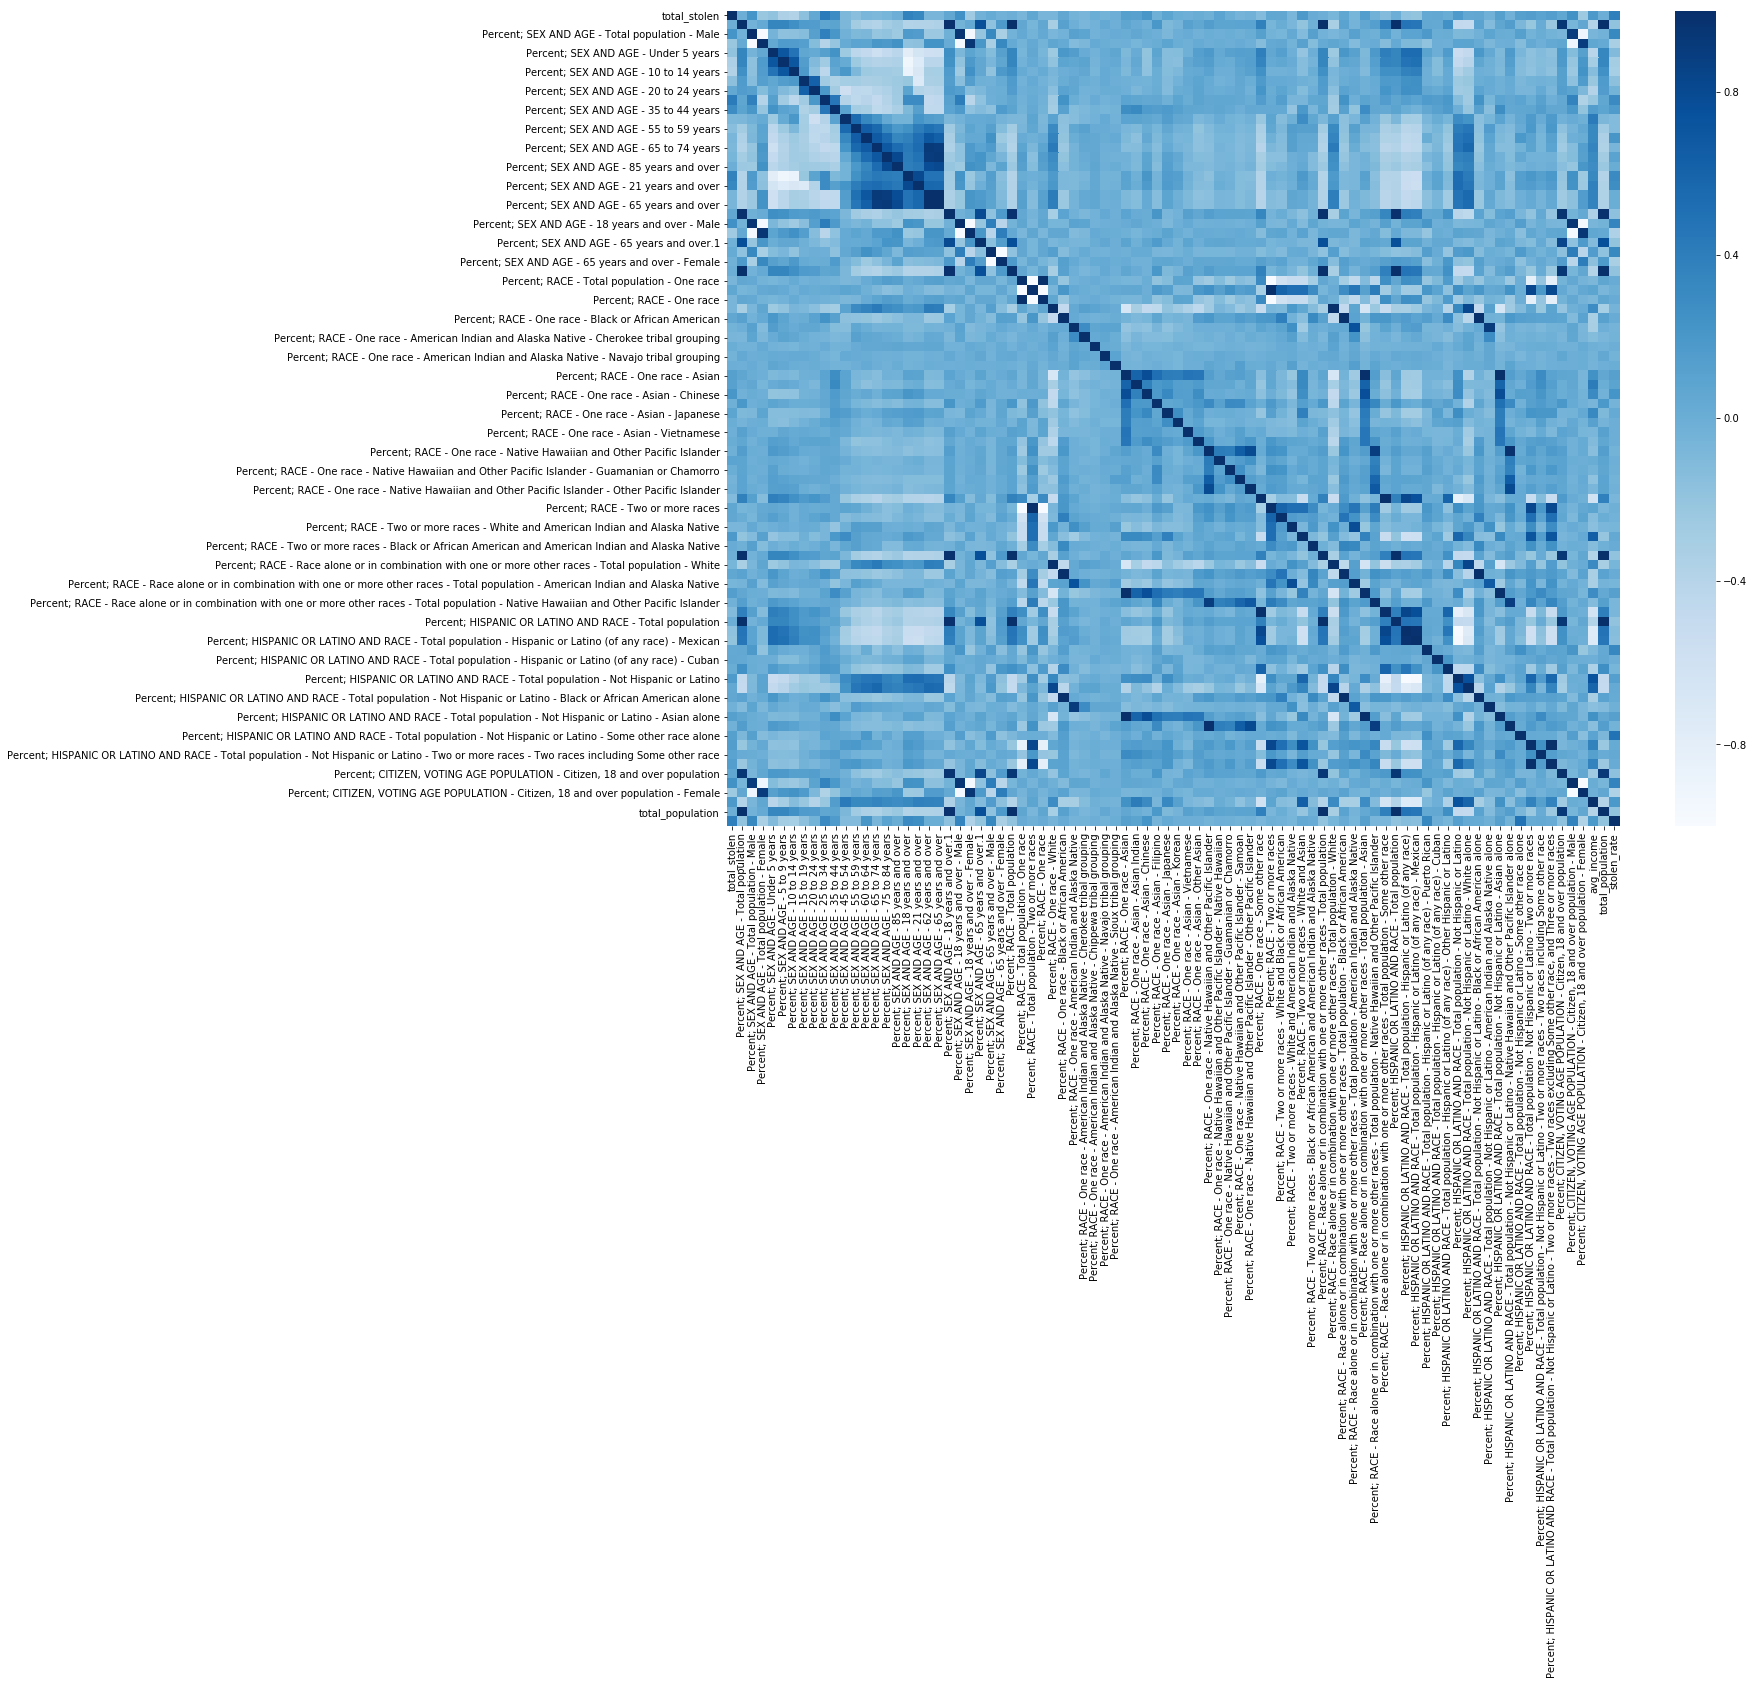

In [64]:
fig, ax = pyplot.subplots(figsize=(20,15))         # Sample figsize in inches

sns.heatmap(bikedata_df.corr(),cmap="Blues",ax=ax)

In [65]:
bikecorr_df = pd.DataFrame(data=bikedata_df.corr())
bikecorr_df['stolen_rate'].sort_values()

Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female                                                           -0.362747
Percent; SEX AND AGE - 18 years and over - Female                                                                                            -0.353007
Percent; SEX AND AGE - 65 years and over - Female                                                                                            -0.317638
Percent; SEX AND AGE - Total population - Female                                                                                             -0.315294
Percent; SEX AND AGE - 10 to 14 years                                                                                                        -0.301488
Percent; SEX AND AGE - 5 to 9 years                                                                                                          -0.287030
Percent; SEX AND AGE - 65 years and over.1                                                    

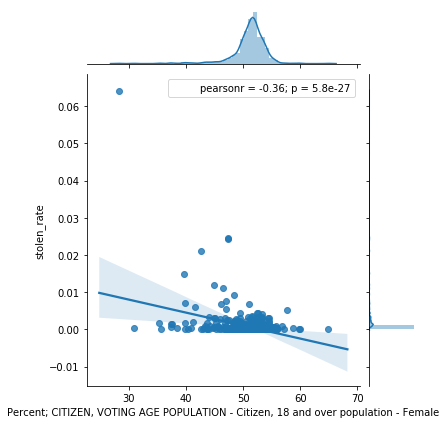

In [66]:
graph = sns.jointplot(y=bikedata_df['stolen_rate'],x=bikedata_df['Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

There is a negative correlation between bike theft rate and neighbourhoods with more women

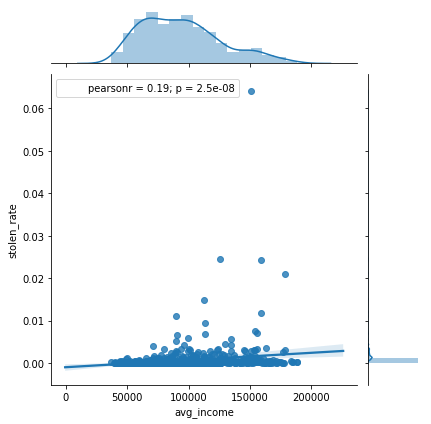

In [67]:
graph = sns.jointplot(y=bikedata_df['stolen_rate'],x=bikedata_df['avg_income'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

Surprisingly, the correlation between stolen rate and a zipcode's average income is very small.

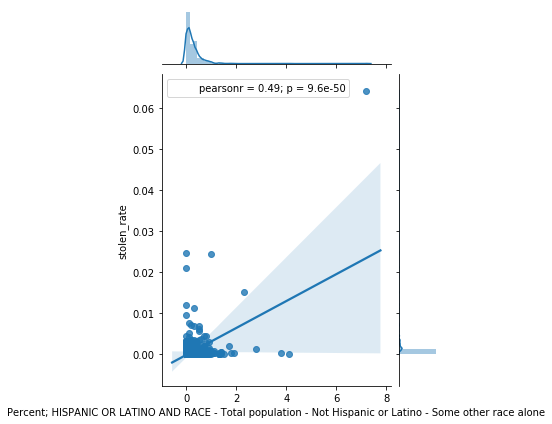

In [68]:
graph = sns.jointplot(y=bikedata_df['stolen_rate'],x=bikedata_df['Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

Although there is a high correlation between bike theft rates and hispanic communities, there is not a lot of confidence in this correlation.

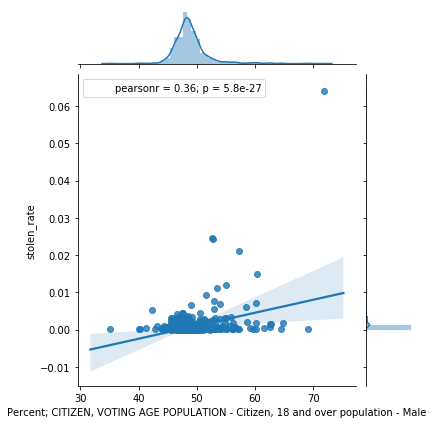

In [69]:
graph = sns.jointplot(y=bikedata_df['stolen_rate'],x=bikedata_df['Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

In [70]:
bikecorr_df = pd.DataFrame(data=bikedata_df.corr())
bikecorr_df['total_stolen'].sort_values()

Percent; SEX AND AGE - 10 to 14 years                                                                                                                                 -0.371343
Percent; SEX AND AGE - 5 to 9 years                                                                                                                                   -0.336139
Percent; SEX AND AGE - 18 years and over - Female                                                                                                                     -0.250829
Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female                                                                                    -0.245185
Percent; SEX AND AGE - Total population - Female                                                                                                                      -0.225512
Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Mexican                    

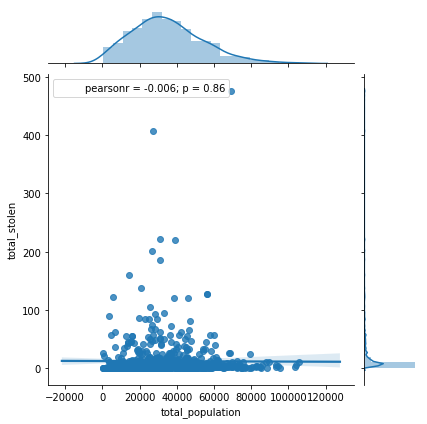

In [71]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['total_population'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

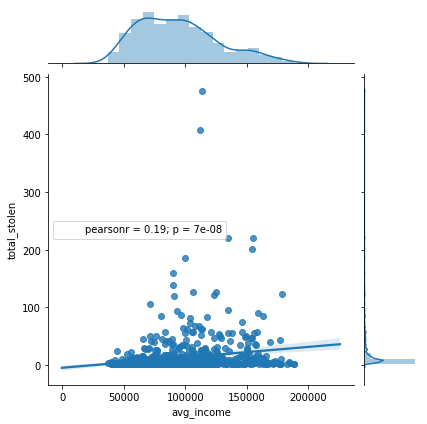

In [72]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['avg_income'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

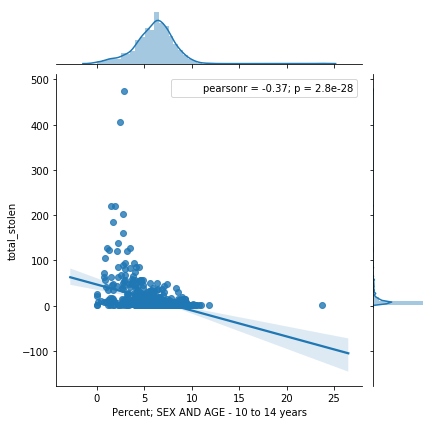

In [73]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['Percent; SEX AND AGE - 10 to 14 years'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

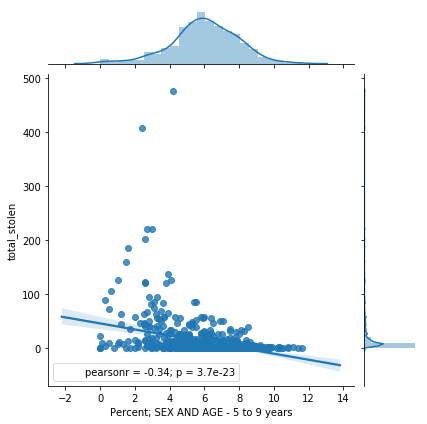

In [74]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['Percent; SEX AND AGE - 5 to 9 years'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

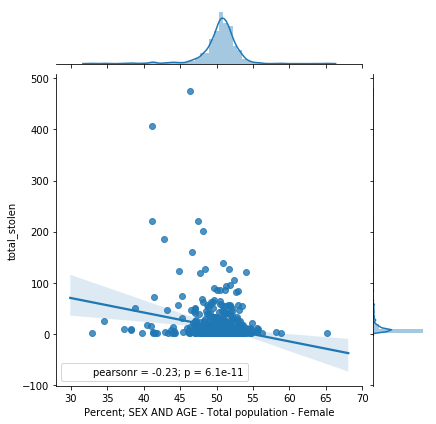

In [75]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['Percent; SEX AND AGE - Total population - Female'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

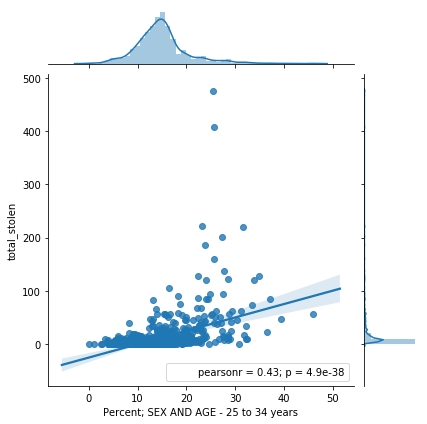

In [76]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['Percent; SEX AND AGE - 25 to 34 years'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

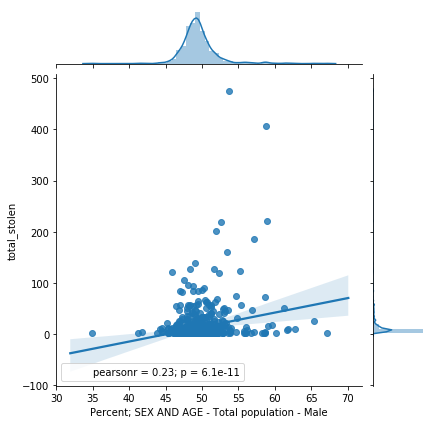

In [77]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['Percent; SEX AND AGE - Total population - Male'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

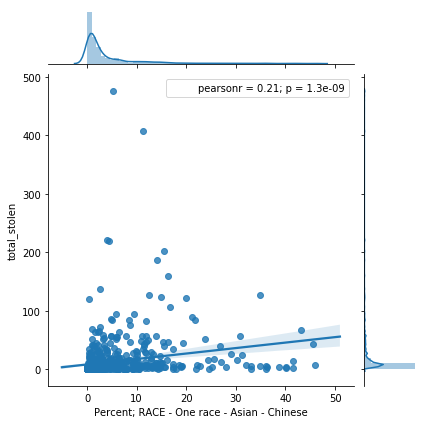

In [78]:
graph = sns.jointplot(y=bikedata_df['total_stolen'],x=bikedata_df['Percent; RACE - One race - Asian - Chinese'],kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

Converse to bike theft in areas with women, there is a positive correlation between bike theft rates and zipcodes that are predominantly male.

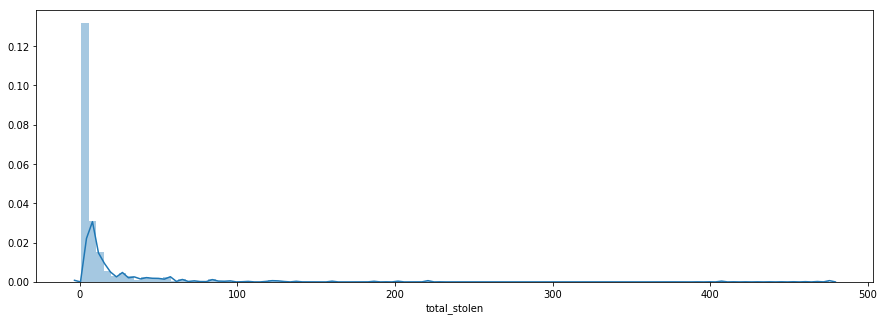

In [79]:
fig, ax = pyplot.subplots(figsize=(15,5))
sns.distplot(bikedata_df['total_stolen'],bins=100, ax=ax)

There are neighbourhoods that are experiencing much more theft than others in California

In [80]:
bikedata_df.describe()

,total_stolen,Percent; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population - Male,Percent; SEX AND AGE - Total population - Female,Percent; SEX AND AGE - Under 5 years,Percent; SEX AND AGE - 5 to 9 years,Percent; SEX AND AGE - 10 to 14 years,Percent; SEX AND AGE - 15 to 19 years,Percent; SEX AND AGE - 20 to 24 years,Percent; SEX AND AGE - 25 to 34 years,...,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races,Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races including Some other race,"Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races - Two races excluding Some other race, and Three or more races","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male","Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female",avg_income,total_population,stolen_rate
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,...,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,12.260341,36480.352798,49.548905,50.451095,5.981509,6.006204,6.035766,6.293796,7.195012,14.972384,...,0.275304,3.177737,0.136375,3.039659,23409.223844,48.859367,51.140633,94176.145095,35057.823601,0.000636
std,31.489617,19976.109159,2.505175,2.505175,1.931633,1.892989,2.040154,3.268019,3.707156,5.371997,...,0.423299,1.596930,0.171624,1.565138,11777.836822,2.980436,2.980436,32536.961564,19213.848077,0.002865
min,1.000000,340.000000,34.900000,32.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,297.000000,35.100000,28.200000,36869.436202,315.000000,0.000010
25%,2.000000,22233.500000,48.300000,49.700000,4.900000,4.900000,4.900000,5.000000,5.300000,11.900000,...,0.100000,2.000000,0.000000,1.900000,15143.500000,47.400000,50.300000,68378.937449,21369.250000,0.000056
50%,4.000000,34340.500000,49.300000,50.700000,6.000000,6.000000,6.200000,6.200000,6.800000,14.500000,...,0.200000,3.000000,0.100000,2.900000,22510.000000,48.500000,51.500000,89846.967480,32978.500000,0.000125
75%,9.000000,48419.250000,50.300000,51.700000,7.100000,7.300000,7.300000,7.300000,8.100000,16.800000,...,0.400000,4.200000,0.200000,4.000000,30684.250000,49.700000,52.600000,113237.783500,46280.750000,0.000359
max,475.000000,106360.000000,67.100000,65.100000,16.900000,11.600000,23.700000,60.800000,38.200000,45.900000,...,7.200000,11.000000,1.200000,11.000000,64495.000000,71.800000,64.900000,188580.246914,105549.000000,0.064039


In [81]:
sns.__version__

'0.9.0'

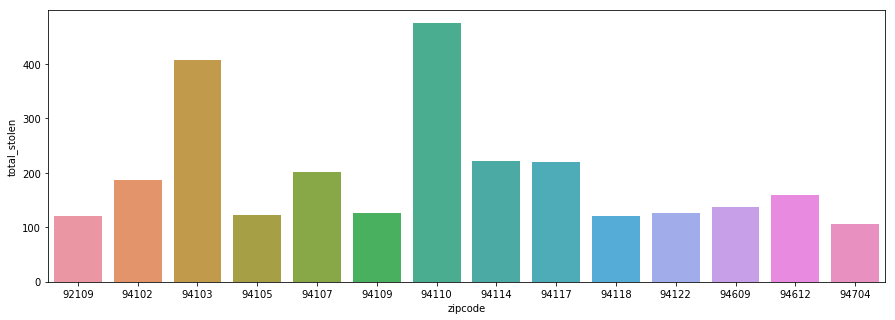

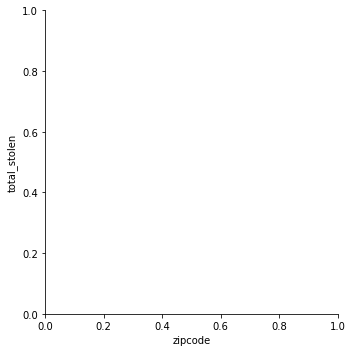

In [82]:
fig, ax = pyplot.subplots(figsize=(15,5))
sns.catplot(y='total_stolen', x='zipcode', kind="bar", data=bikedata_df[bikedata_df['total_stolen']>100],ax=ax)

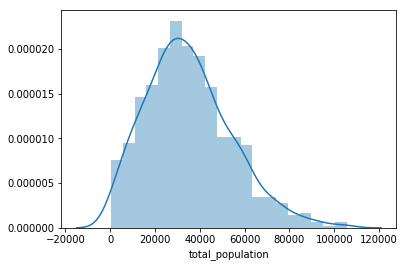

In [83]:
sns.distplot(bikedata_df.total_population)

In [84]:
bikedata_df.shape

(822, 87)

The difference between the top two zipcodes with the most theft and the zipcodes with the least theft are very different - at least 2x!

# Part 3: Technical Notebook

*A detailed Jupyter Notebook with a summary of your analysis, approach, and evaluation metrics.*

Note: Here are some things to consider in your notebook: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, and any relationships between your target and independent variables.

In [85]:
# Import the Machine Learning Libraries

# Data cleaning for machine learning models
from sklearn.model_selection import train_test_split #split data into testing and training data
from sklearn.feature_selection import SelectKBest # identify best X that may predict Y
from sklearn.model_selection import KFold #Cross Validation
from sklearn.feature_selection import mutual_info_regression #needed for SelectKBest
from sklearn.preprocessing import StandardScaler #handle outliers after selecting K best guess variables that predict Y
from sklearn.feature_selection import VarianceThreshold


# Machine Learning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression #Linear Regression and Lasso
#reg = LinearRegression(fit_intercept=True)
#fit_intercept = True; hyper parameter for linear regression, add one-extra term - a start value (a starting weight); rarely False
from sklearn import svm #Support Vector Machines
from sklearn import tree # Decision Trees
from sklearn import linear_model #Ridge Regression
from sklearn.linear_model import ElasticNet # Elastic Net

# Error Measures
from sklearn.dummy import DummyRegressor
# Use DummyRegressor to compare your linear regression to the dumbest possible

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_auc_score


## Random Forest

Using Random Forest because:
1. Interpretable
2. Can handle a lot of features

In [86]:
# Read in the data
bikedata_ml = bikedata_df.copy()

y=bikedata_ml['total_stolen']
X=bikedata_ml.drop(columns=['stolen_rate','zipcode','total_stolen'])

# we make our test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

print (X_train.shape, X_val.shape, X_test.shape)

(402, 84) (173, 84) (247, 84)


In [87]:
random_forest = RandomForestRegressor(max_depth=None, random_state=0, n_estimators=100)

random_forest.fit(X_train, y_train)

print('Random Forest Train Score: ', random_forest.score(X_train,y_train))
print('Random Forest Validation Score: ', random_forest.score(X_val,y_val))
print('Random Forest Train-Validation Mean Absolute Error: ', mean_absolute_error(random_forest.predict(X_val), y_val))
print('Random Forest Train-Validation Mean Squared Error: ', mean_squared_error(random_forest.predict(X_train), y_train))


Random Forest Train Score:  0.8861060739815301
Random Forest Validation Score:  -0.05221306026588035
Random Forest Train-Validation Mean Absolute Error:  11.62757225433526
Random Forest Train-Validation Mean Squared Error:  173.67248482587064


In [88]:
# Determine the variance
print(y_train.mean())
print(y_train.std())

13.106965174129353
39.098137300807544


Although the Train Score is quite good, the Validation Score has a bit to be desired. Looking at the mean and standard deviation of total bikes stolen, the variance is quite large which may explain the extreme error measures.

Looking at the distribution of the errors, there are outliers that are causing the validation score to be so poor. 

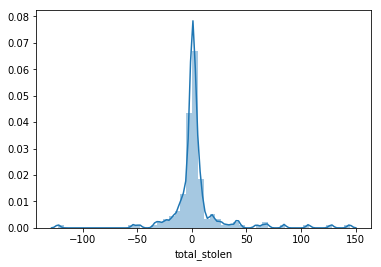

In [89]:
sns.distplot(random_forest.predict(X_val)- y_val)

Despite these errors, the Random Forest Regressor is able to identify the important features.

In [90]:
feature_importances = pd.DataFrame(random_forest.feature_importances_, index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
select_features = feature_importances[feature_importances['importance']>0]
select_features.head(10)

,importance
Percent; SEX AND AGE - 25 to 34 years,0.154165
Percent; SEX AND AGE - 21 years and over,0.062026
Percent; SEX AND AGE - 10 to 14 years,0.048069
Percent; SEX AND AGE - Total population - Female,0.045923
Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone,0.045895
Percent; SEX AND AGE - 45 to 54 years,0.032583
Percent; SEX AND AGE - 35 to 44 years,0.032227
Percent; RACE - One race - Asian - Filipino,0.031158
Percent; SEX AND AGE - 15 to 19 years,0.028294
Percent; RACE - One race - Some other race,0.026879


### Take the log of total_stolen to curve the variance

In [91]:
# Read in the data
bikedata_ml = bikedata_df.copy()

y=np.log1p(bikedata_ml['total_stolen'])
X=bikedata_ml.drop(columns=['stolen_rate','zipcode','total_stolen'])

# we make our test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print (X_train.shape, X_val.shape, X_test.shape)

(460, 84) (115, 84) (247, 84)


In [92]:

random_forest = RandomForestRegressor(max_depth=None, random_state=0, n_estimators=100)

random_forest.fit(X_train, y_train)

print('Random Forest Train Score: ', random_forest.score(X_train,y_train))
print('Random Forest Validation Score: ', random_forest.score(X_val,y_val))
print('Random Forest Train-Validation Mean Absolute Error: ', mean_absolute_error(np.exp(random_forest.predict(X_val)), np.exp(y_val)))
print('Random Forest Train-Validation Mean Squared Error: ', mean_squared_error(np.exp(random_forest.predict(X_train)), np.exp(y_train)))


Random Forest Train Score:  0.933660054352642
Random Forest Validation Score:  0.6614621779580919
Random Forest Train-Validation Mean Absolute Error:  7.902225721779347
Random Forest Train-Validation Mean Squared Error:  273.65829195839115


In [93]:
print(np.exp(y_train).mean())
print(np.exp(y_train).std())

13.030434782608696
31.18996451618358


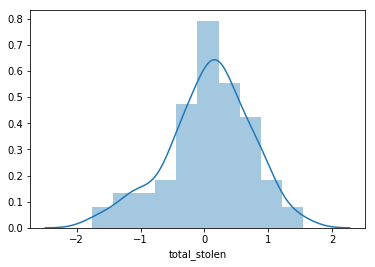

In [94]:
sns.distplot(random_forest.predict(X_val)- y_val)

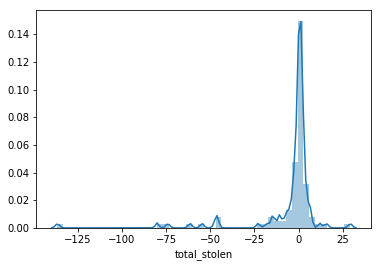

In [95]:
sns.distplot(np.exp(random_forest.predict(X_val))- np.exp(y_val))

In [96]:
feature_importances = pd.DataFrame(random_forest.feature_importances_, index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
select_features = feature_importances[feature_importances['importance']>0]
select_features.head(10)

,importance
Percent; SEX AND AGE - 25 to 34 years,0.357450
Percent; RACE - One race - Asian - Chinese,0.065566
avg_income,0.042560
Percent; SEX AND AGE - 20 to 24 years,0.036210
Percent; SEX AND AGE - 15 to 19 years,0.026953
Percent; SEX AND AGE - 35 to 44 years,0.024794
Percent; SEX AND AGE - 10 to 14 years,0.023931
"Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population",0.023449
Percent; RACE - One race - Asian - Japanese,0.019376
Percent; SEX AND AGE - 65 years and over.1,0.019064


## Follow Up: Predictions when values are binned

In [97]:
# Read in the data
bikedata_ml = bikedata_df.copy()

y=bikedata_ml['total_stolen']
X=bikedata_ml.drop(columns=['stolen_rate','zipcode','total_stolen'])

In [98]:
(bikedata_ml.total_stolen > 100).count()

822

In [99]:
#Assign the total_stolen into bins
bikedata_ml['total_stolen'], bins = pd.qcut(x=y, q=4, labels=[1,2,3,4], duplicates='drop', retbins=True)
y=bikedata_ml['total_stolen']

In [100]:
bins

array([  1.,   2.,   4.,   9., 475.])

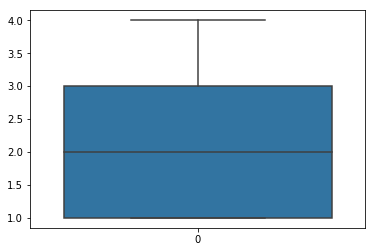

In [101]:
sns.boxplot(data=y)

The bins created are not very interpretable because of how the data is split into quartiles:

- 1-2 stolen
- 2-4 stolen
- 4-0 stolen
- 9-475 stolen <-- weird


In [102]:
# Identify what bins
print('max: ',y.max())
print('min: ',y.min())

max:  4
min:  1


In [103]:
y.value_counts()

1    307
4    199
2    159
3    157
Name: total_stolen, dtype: int64

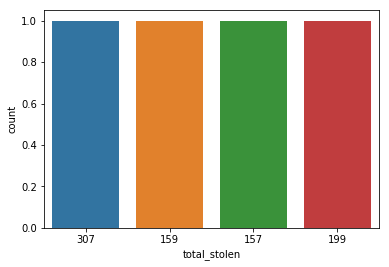

In [104]:
sns.countplot(x=y.value_counts(), data=y.value_counts(), order=[307,159,157,199])

In [105]:
# we make our test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

print (X_train.shape, X_val.shape, X_test.shape)

(402, 84) (173, 84) (247, 84)


In [106]:
random_forest = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100)

random_forest.fit(X_train, y_train)

print('Random Forest Train Score: ', random_forest.score(X_train,y_train))
print('Random Forest Validation Score: ', random_forest.score(X_val,y_val))
print('Random Forest Train-Validation Mean Absolute Error: ', mean_absolute_error(random_forest.predict(X_val), y_val))
print('Random Forest Train-Validation Mean Squared Error: ', mean_squared_error(random_forest.predict(X_train), y_train))


Random Forest Train Score:  1.0
Random Forest Validation Score:  0.5780346820809249
Random Forest Train-Validation Mean Absolute Error:  0.6358381502890174
Random Forest Train-Validation Mean Squared Error:  0.0


In [107]:
from sklearn.metrics import classification_report

In [108]:
print(classification_report(y_val, random_forest.predict(X_val)))

             precision    recall  f1-score   support

          1       0.58      0.90      0.70        68
          2       0.00      0.00      0.00        34
          3       0.47      0.26      0.33        35
          4       0.70      0.83      0.76        36

avg / total       0.47      0.58      0.50       173



In [109]:
feature_importances = pd.DataFrame(random_forest.feature_importances_, index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
select_features = feature_importances[feature_importances['importance']>0]
select_features.head(10)

,importance
Percent; SEX AND AGE - 25 to 34 years,0.037857
Percent; SEX AND AGE - 10 to 14 years,0.034848
Percent; SEX AND AGE - 18 years and over,0.026555
Percent; SEX AND AGE - 15 to 19 years,0.023343
Percent; RACE - One race - Asian - Chinese,0.021587
Percent; SEX AND AGE - 21 years and over,0.021322
Percent; SEX AND AGE - 55 to 59 years,0.019162
Percent; SEX AND AGE - 20 to 24 years,0.017463
Percent; RACE - One race - Asian - Asian Indian,0.017395
Percent; SEX AND AGE - 35 to 44 years,0.016854


# Next Steps

Currently, my model can predict the extreme scenarios - whether my area can experience high theft (475+ thefts) or low theft (1 theft.)

The largest issue I encountered are outliers as they are biasing my model. 

Next steps to provide more meaning predictions on bike theft surround the topic of - how do I deal with these outliers? I would propose the following:
1. Classify zipcodes with high theft versus low theft more clearly and predict within these two classifiers.
2. Predict likelihood of stolen bikes in large cities.
3. Predict likelihood of stolen bikes in small cities.

# Appendix

After 9 weeks of painstaking data cleaning and moments of doubt and extreme clarity, I realized that I had been going down a deep path in the wrong direction. Through the wise words of [Alex J Lin](https://github.com/ajlin), *"...sometimes research doesnt turn out the way you want it to. but you still did the work and are still learning..."* I will honestly say, I learned a whole lot about data cleaning in this project and the below are the toils of my trouble. Enjoy.

# Learning 1: All positive data does not a supervised model make. 

In [110]:
# Data cleaning, exploration, and analysis tools
import pandas as pd
import seaborn as sns
import numpy as np
from ast import literal_eval
import re as re


### Clean the BikeIndex data

In [111]:
# Import the csv of stolen and not stolen bike data and store in a pandas DataFrame
bike_data_appendix = pd.read_csv('bike_index_api_stolenessall.csv')
bike_df_appendix = pd.DataFrame(data=bike_data_appendix)
bike_df_appendix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188574 entries, 0 to 188573
Data columns (total 14 columns):
Unnamed: 0           188574 non-null int64
date_stolen          62097 non-null float64
frame_colors         188574 non-null object
frame_model          170000 non-null object
id                   188574 non-null int64
is_stock_img         188574 non-null bool
large_img            78875 non-null object
manufacturer_name    188567 non-null object
serial               188211 non-null object
stolen               188574 non-null bool
stolen_location      61129 non-null object
thumb                78875 non-null object
title                188573 non-null object
year                 133836 non-null float64
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 17.6+ MB


In [112]:
bike_df_appendix.head()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year
0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN
1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN
2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN
3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0
4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0


This bike data has all datapoints ever collected in the BikeIndex API. What I really want are datapoints for bikes that are in San Francisco.

**Assumption 1:** I am going to narrow this data set's positive signal for stolen to bikes that have some representation of California as evident by a "stolen_location" value that contains "CA", "California", or "San Francisco" in it. I am including all data points that are NaN in stolen_location as that will be my signal for not stolen bikes.

In [113]:
bike_df_clean_appendix = bike_df_appendix.copy()
bike_df_clean_appendix = bike_df_clean_appendix[bike_df_clean_appendix['stolen_location'].apply(str).str.contains('CA|California|San Francisco|')]

In [114]:
# Confirm that there are both stolen and non-stolen datapoints
bike_df_clean_appendix['stolen'].value_counts()

False    126494
True      62080
Name: stolen, dtype: int64

In [115]:
def split_zipcode(x):
    array=re.findall('\d{5}',str(x))
    if len(array)==0:
        return None
    else:
        return array[0]
            
bike_df_clean_appendix['stolen_zipcode'] = bike_df_clean_appendix['stolen_location'].apply(split_zipcode)

In [116]:
# Confirm that the zipcode dad has been successfully parsed out into a new column
bike_df_clean_appendix.head()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode
0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN,None
1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN,None
2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN,None
3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0,None
4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0,None


In [117]:
# The size of the California dataset is much smaller than the original dataset
bike_df_clean_appendix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188574 entries, 0 to 188573
Data columns (total 15 columns):
Unnamed: 0           188574 non-null int64
date_stolen          62097 non-null float64
frame_colors         188574 non-null object
frame_model          170000 non-null object
id                   188574 non-null int64
is_stock_img         188574 non-null bool
large_img            78875 non-null object
manufacturer_name    188567 non-null object
serial               188211 non-null object
stolen               188574 non-null bool
stolen_location      61129 non-null object
thumb                78875 non-null object
title                188573 non-null object
year                 133836 non-null float64
stolen_zipcode       54772 non-null object
dtypes: bool(2), float64(2), int64(2), object(9)
memory usage: 20.5+ MB


In [118]:
# Convert the date_stolen into something readable and extract the year
bike_df_clean_appendix['date_stolen'] = pd.to_datetime(bike_df_clean_appendix['date_stolen'],unit='s')
bike_df_clean_appendix['year_stolen'] = bike_df_clean_appendix['date_stolen'].dt.year

In [119]:
# Confirm that the year has been extracted correctly.
bike_df_clean_appendix

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode,year_stolen
0,0,NaT,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN,None,NaN
1,1,NaT,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN,None,NaN
2,2,NaT,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN,None,NaN
3,3,NaT,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0,None,NaN
4,4,NaT,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0,None,NaN
5,5,NaT,['Green'],Volpe,355566,False,NaN,Bianchi,8309,False,NaN,NaN,2006 Bianchi Volpe,2006.0,None,NaN
6,6,NaT,['Blue'],Kirsten,120716,False,NaN,Klein Bikes,absent,False,NaN,NaN,1988 Klein Bikes Kirsten,1988.0,None,NaN
7,7,NaT,['Yellow or Gold'],NaN,366387,False,NaN,SE Racing,8=1F61210744,False,NaN,NaN,SE Racing,NaN,None,NaN
8,8,NaT,['Black'],xmr,355559,False,NaN,motorino xmr,882016052388493,False,NaN,NaN,2017 motorino xmr xmr,2017.0,None,NaN
9,9,NaT,"['White', 'Blue']",Gran Fondo 1.3 C,392894,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Fuji,FJ151CJ00265,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2013 Fuji Gran Fondo 1.3 C,2013.0,None,NaN


In [120]:
# Check to see if the data is clean for year, as in, there are no repeat years or strange ways to notate the year
year_stolen = []
year_stolen = bike_df_clean_appendix['year_stolen'].unique()
year_stolen.sort()
year_stolen

array([1970., 1971., 1972., 1979., 1985., 1986., 1990., 1994., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018.,   nan])

**Assumption 2:** Knowing that my San Francisco City Survey Data recommends only using the data from 2015 forward and the most complete data is from the survey conducted in 2017, I am going to base my model on bike data from 2015 forward and assume that the state of San Francisco between 2015 and present day is not much different than what was captured in 2017.

Looking at the completeness of the BikeIndex dataset, it appears the data is richer in the years after 2014.

In [121]:
bike_df_clean_appendix.groupby('year_stolen').count()

,Unnamed: 0,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode
year_stolen,,,,,,,,,,,,,,,
1970.0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,0
1971.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1972.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1979.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1985.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1
1986.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1
1990.0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
1994.0,3,3,3,3,3,3,0,3,3,3,3,0,3,3,3
1996.0,2,2,2,2,2,2,0,2,2,2,2,0,2,2,1


In [122]:
# Select data from year_stolen 2015 to 2018
bike_df_final_appendix = bike_df_clean_appendix[bike_df_clean_appendix['year_stolen'].isin(['2018','2017','2016','2015',None])]
bike_df_final_appendix['year_stolen'].unique()

array([  nan, 2017., 2018., 2016., 2015.])

In [123]:
bike_df_final_appendix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161992 entries, 0 to 188573
Data columns (total 16 columns):
Unnamed: 0           161992 non-null int64
date_stolen          35515 non-null datetime64[ns]
frame_colors         161992 non-null object
frame_model          145268 non-null object
id                   161992 non-null int64
is_stock_img         161992 non-null bool
large_img            67245 non-null object
manufacturer_name    161985 non-null object
serial               161629 non-null object
stolen               161992 non-null bool
stolen_location      34830 non-null object
thumb                67245 non-null object
title                161991 non-null object
year                 111914 non-null float64
stolen_zipcode       29988 non-null object
year_stolen          35515 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 18.8+ MB


In [124]:
# Store final data into csv
bike_df_final_appendix.to_csv(path_or_buf='/Users/lizchan/ds_foundations/final_project/bike_data_clean_appendix.csv')

### Cleaning the San Francisco Survey Data

In [125]:
# Import the survey data
survey_data = pd.read_csv('San_Francisco_City_Survey_Data_1996-2017.csv')
survey_df = pd.DataFrame(data=survey_data)
total_columns = survey_df.columns
print(len(total_columns))
print(survey_df.columns.nunique())

92
92


Seeing there are 92 columns in this survey dataset, I read through the Survey data dictionary to understand what was available to me and selected columns that could be relevant to zipcodes where bikes are stolen. 

**Assumption 3:** I selected columns that are organized, according to the data dictionary, into "survey" and "demographics". I made the assumption that demographics of a zipcode are variables that can predict whether or not a bike will get stolen.

In [126]:
# Data Dictionary for survey data
column_names = {
    'id':'Unique id',
    'year':'Survey year',
    'mode':'survey mode',
    'language':'survey language',
    'dlivedsf':'Length of SF residence 1996-2009 (Groupings change in 2011)', #Made Contiguous 
    'primlang_1':'primary language 1',
    'primlang_2':'primary language',
    'primlang_3':'primary language',
    'primlang_4':'primary_language',
    'dage':'Respondents age group (Age groups change in 2011, 2017)', #Made Contiguous 
    'dethnic':'Respondents ethnicity',
    'mixed_1':'mixed race or ethnics',
    'mixed_2':'mixed race or ethnics',
    'mixed_3':'mixed race or ethnics',
    'mixed_4':'mixed race or ethnics',
    'deduc':'Respondents highest education completed',
    'dincome':'Household income year prior to survey', #Made Contiguous 
    'dhouse':'Number of people in household', #Made Contiguous 
    'ownrenhm':'Own or rent home',
    'gender':'Respondents sex',
    'dsexornt':'Respondents sexual orientation',
    'zipcode':'zipcode',
    'district':'Supervisorial District',
    'movesf':'Likelihood of moving away from SF in the next 3 years',
    'disablephys':'physically disabled',
    'disablement':'mentally disabled'    
}

After looking at the demographic data, I noticed that there are fields that may not relate to bike-stolenness.

**Assumption 4:** Mentally disabled or physically disabled persons are less likely to ride bikes. I removed this column for consideration in my model.

**Assumption 5:** Survey year, mode, survey language, years lived in San Francisco, age, ethnicity, education, income, number of people in household, gender, and likelihood of moving away from SF are variables to consider in likelihood to have a bike stolen.

**Assumption 6:** When making values contiguous, I assigned the upper bound of the following columns to be:

- dlivedsf: 30+ changed to 40; years lived in SF
- dage: 65+ changed to 65; age
- dincome: 200001+ changed to 300000; income
- dhouse: 6 or more changed to 6; number of people in household

In [127]:
# Collect an array of column titles to keep

survey_info = ['year'] # Columns classified as survey-related
demographics = ['dlivedsf','dage','dethnic','deduc','dincome','dhouse','gender','zipcode','movesf'] # Columns classified as demographics-related
active_columns = survey_info + demographics

# Collect an array of column titles to discard
discard_columns = []

for t in total_columns:
    if t not in active_columns:
        discard_columns.append(t)
        
# Create clean DataFrame with relevant survey columns( active_columns)

survey_df_clean = survey_df.copy()
survey_df_clean = survey_df_clean.drop(columns=discard_columns)
survey_df_clean = survey_df_clean[survey_df_clean['year'].isin(['2018','2017','2016','2015'])]


In [128]:
survey_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4345 entries, 16699 to 37971
Data columns (total 10 columns):
year        4345 non-null int64
dhouse      4345 non-null float64
dlivedsf    4345 non-null float64
movesf      4345 non-null float64
dincome     4345 non-null float64
dage        4345 non-null float64
gender      4345 non-null float64
dethnic     4345 non-null float64
deduc       4345 non-null float64
zipcode     2166 non-null float64
dtypes: float64(9), int64(1)
memory usage: 373.4 KB


Because I am planning to merge the survey data with my bike data using zipcodes, any data that does not have a zipcode to link is unusable. I am discarding all survey data that has a missing zipcode.

In [129]:
# Drop null zipcodes
survey_df_clean_null = survey_df_clean[survey_df_clean.isnull().any(axis=1)]
survey_df_clean_value = survey_df_clean.copy()
survey_df_clean_value = survey_df_clean_value.dropna()

In [130]:
print('Years of survey with null zipcodes: ',survey_df_clean_null['year'].unique())
print('Years of survey with zipcodes: ',survey_df_clean_value['year'].unique())

Years of survey with null zipcodes:  [2015]
Years of survey with zipcodes:  [2017]


The survey data with zipcodes on which I can merge to my BikeIndex dataset is from 2017. (See **Assumption 2**)

In [131]:
# Check data size. Appears deceptively complete. 
survey_df_clean_value.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 16699 to 37971
Data columns (total 10 columns):
year        2166 non-null int64
dhouse      2166 non-null float64
dlivedsf    2166 non-null float64
movesf      2166 non-null float64
dincome     2166 non-null float64
dage        2166 non-null float64
gender      2166 non-null float64
dethnic     2166 non-null float64
deduc       2166 non-null float64
zipcode     2166 non-null float64
dtypes: float64(9), int64(1)
memory usage: 186.1 KB


In [132]:
# Manually type in the survey and demographics key into dictionaries
# Note any "not available" datapoints as NaN
# Convert columns that can be contiguous

#Made Contiguous
dlivedsf_dict={
    1:2,
    2:5,
    3:10,
    4:20,
    5:30,
    6:40, #30+; I gave this value an extra subjective weight
    7:None
}

# Made contiguous
dage_dict={
    1:24,
    2:34,
    3:44,
    4:54,
    5:59,
    6:64,
    7:65, #65+
    8:None
}

dethnic_dict={
    1:'Black/African American',
    2:'Asian or Pacific Islander',
    3:'Latino/Hispanic',
    4:'Native American/Indian',
    5:'White/Caucasian',
    6:'Other',
    7:'Mixed Ethnicity',
    8:'Dont know',
    9:None,
    10:'Pacific Islander',
    11:'Arab / Middle Eastern /North African ( 2015 Only); Arab,Middle Eastern, South Asian (2017)',
    12:'Mixed Unspecified',
    13:'Caribbean (2017)'
}

deduc_dict={
    1:'Less than high school',
    2:'High school',
    3:'Less than 4 years of college',
    4:'4 or more years of college/Post Graduate',
    5:None,
}

# Made contiguous
dincome_dict={
    1:10000,
    2:25000,
    3:35000,
    4:50000,
    5:100000,
    6:200000,
    7:300000, #30000 +
    8:None
}

# Made contiguous
dhouse_dict={
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6, #6 ore more
    7:None,
}

gender_dict={
    1:'Female',
    2:'Male',
    3:'Other',
    4:None,
}

movesf_dict={
    1:'Very likely',
    2:'Somewhat likely',
    3:'Not too likely',
    4:'Not at all likely',
    5:None
}

In [133]:
survey_df_clean_value.head()

,year,dhouse,dlivedsf,movesf,dincome,dage,gender,dethnic,deduc,zipcode
16699,2017,1.0,3.0,2.0,2.0,2.0,1.0,2.0,2.0,94114.0
18495,2017,2.0,6.0,4.0,7.0,7.0,2.0,5.0,4.0,94124.0
18885,2017,2.0,6.0,4.0,3.0,4.0,2.0,1.0,3.0,94115.0
20949,2017,2.0,4.0,2.0,6.0,3.0,1.0,4.0,4.0,94110.0
29172,2017,2.0,3.0,4.0,8.0,4.0,1.0,9.0,4.0,94132.0


In [134]:
# Apply dictionary to dataset
survey_df_clean_value_a= survey_df_clean_value.copy()
survey_df_clean_value_a['dhouse'] = survey_df_clean_value_a['dhouse'].map(dhouse_dict)
survey_df_clean_value_a['dlivedsf'] = survey_df_clean_value_a['dlivedsf'].map(dlivedsf_dict)
survey_df_clean_value_a['movesf'] = survey_df_clean_value_a['movesf'].map(movesf_dict)
survey_df_clean_value_a['dincome'] = survey_df_clean_value_a['dincome'].map(dincome_dict)
survey_df_clean_value_a['dage'] = survey_df_clean_value_a['dage'].map(dage_dict)
survey_df_clean_value_a['gender'] = survey_df_clean_value_a['gender'].map(gender_dict)
survey_df_clean_value_a['dethnic'] = survey_df_clean_value_a['dethnic'].map(dethnic_dict)
survey_df_clean_value_a['deduc'] = survey_df_clean_value_a['deduc'].map(deduc_dict)

survey_df_clean_value_a.head()

,year,dhouse,dlivedsf,movesf,dincome,dage,gender,dethnic,deduc,zipcode
16699,2017,1.0,10.0,Somewhat likely,25000.0,34.0,Female,Asian or Pacific Islander,High school,94114.0
18495,2017,2.0,40.0,Not at all likely,300000.0,65.0,Male,White/Caucasian,4 or more years of college/Post Graduate,94124.0
18885,2017,2.0,40.0,Not at all likely,35000.0,54.0,Male,Black/African American,Less than 4 years of college,94115.0
20949,2017,2.0,20.0,Somewhat likely,200000.0,44.0,Female,Native American/Indian,4 or more years of college/Post Graduate,94110.0
29172,2017,2.0,10.0,Not at all likely,NaN,54.0,Female,None,4 or more years of college/Post Graduate,94132.0


In [135]:
# Check to see that NaN values are accurately recorded
survey_df_clean_value_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 16699 to 37971
Data columns (total 10 columns):
year        2166 non-null int64
dhouse      2145 non-null float64
dlivedsf    2159 non-null float64
movesf      2137 non-null object
dincome     1781 non-null float64
dage        2113 non-null float64
gender      2133 non-null object
dethnic     2066 non-null object
deduc       2124 non-null object
zipcode     2166 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 186.1+ KB


In [136]:
# Use DummyVariables to quantify qualitative data into probabilities

survey_df_clean_value_a_dummies = pd.get_dummies(survey_df_clean_value_a)
survey_df_final = survey_df_clean_value_a_dummies.copy()
survey_df_final = survey_df_final.groupby('zipcode').mean()

survey_df_final.head()

,year,dhouse,dlivedsf,dincome,dage,movesf_Not at all likely,movesf_Not too likely,movesf_Somewhat likely,movesf_Very likely,gender_Female,...,dethnic_Latino/Hispanic,dethnic_Mixed Ethnicity,dethnic_Native American/Indian,dethnic_Other,dethnic_Pacific Islander,dethnic_White/Caucasian,deduc_4 or more years of college/Post Graduate,deduc_High school,deduc_Less than 4 years of college,deduc_Less than high school
zipcode,,,,,,,,,,,,,,,,,,,,,
94102.0,2017,2.246914,22.951220,77323.943662,48.691358,0.500000,0.182927,0.170732,0.134146,0.585366,...,0.000000,0.024390,0.378049,0.0,0.097561,0.109756,0.414634,0.243902,0.231707,0.085366
94103.0,2017,2.294872,21.076923,111805.555556,48.423077,0.474359,0.217949,0.141026,0.166667,0.628205,...,0.025641,0.000000,0.435897,0.0,0.102564,0.205128,0.538462,0.179487,0.256410,0.025641
94104.0,2017,2.545455,10.727273,113500.000000,40.250000,0.250000,0.250000,0.250000,0.166667,0.750000,...,0.083333,0.000000,0.333333,0.0,0.000000,0.250000,0.583333,0.333333,0.000000,0.083333
94105.0,2017,1.944444,14.555556,189666.666667,45.833333,0.444444,0.222222,0.111111,0.222222,0.611111,...,0.055556,0.000000,0.500000,0.0,0.055556,0.000000,0.944444,0.055556,0.000000,0.000000
94107.0,2017,2.392157,26.450980,156914.893617,50.620000,0.568627,0.156863,0.176471,0.098039,0.529412,...,0.019608,0.019608,0.588235,0.0,0.078431,0.058824,0.647059,0.117647,0.196078,0.039216


In [137]:
# Store as a CSV
survey_df_final.to_csv(path_or_buf='/Users/lizchan/ds_foundations/final_project/survey_clean_2017.csv')

In [138]:
# Import CSVs

bike_df_appendix = pd.read_csv('bike_data_clean_appendix.csv')
bike_df_appendix = pd.DataFrame(data=bike_df_appendix)

survey_df = pd.read_csv('survey_clean_2017.csv')
survey_df = pd.DataFrame(data=survey_df)

In [139]:
bike_df_appendix.head()

,Unnamed: 0,Unnamed: 0.1,date_stolen,frame_colors,frame_model,id,is_stock_img,large_img,manufacturer_name,serial,stolen,stolen_location,thumb,title,year,stolen_zipcode,year_stolen
0,0,0,NaN,['Green'],Single track,120584,False,NaN,Trek,wtu1936134m,False,NaN,NaN,Trek Single track,NaN,NaN,NaN
1,1,1,NaN,['Black'],NaN,401681,False,NaN,KHS Bicycles,R15N001878,False,NaN,NaN,KHS Bicycles,NaN,NaN,NaN
2,2,2,NaN,"['Silver, gray or bare metal']",Precept deluze,370419,False,NaN,Kona,h4ah3287,False,NaN,NaN,Kona Precept deluze,NaN,NaN,NaN
3,3,3,NaN,['Blue'],Lexa SL (Compact),357089,True,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,Trek,wtu194c0974h,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/6...,2012 Trek Lexa SL (Compact),2012.0,NaN,NaN
4,4,4,NaN,"['Silver, gray or bare metal']",7300 FX,120343,True,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,Trek,tbi0407c25dl064,False,NaN,https://bikebook.s3.amazonaws.com/uploads/Fr/2...,2004 Trek 7300 FX,2004.0,NaN,NaN


In [140]:
survey_df.head()

,zipcode,year,dhouse,dlivedsf,dincome,dage,movesf_Not at all likely,movesf_Not too likely,movesf_Somewhat likely,movesf_Very likely,...,dethnic_Latino/Hispanic,dethnic_Mixed Ethnicity,dethnic_Native American/Indian,dethnic_Other,dethnic_Pacific Islander,dethnic_White/Caucasian,deduc_4 or more years of college/Post Graduate,deduc_High school,deduc_Less than 4 years of college,deduc_Less than high school
0,94102.0,2017,2.246914,22.951220,77323.943662,48.691358,0.500000,0.182927,0.170732,0.134146,...,0.000000,0.024390,0.378049,0.0,0.097561,0.109756,0.414634,0.243902,0.231707,0.085366
1,94103.0,2017,2.294872,21.076923,111805.555556,48.423077,0.474359,0.217949,0.141026,0.166667,...,0.025641,0.000000,0.435897,0.0,0.102564,0.205128,0.538462,0.179487,0.256410,0.025641
2,94104.0,2017,2.545455,10.727273,113500.000000,40.250000,0.250000,0.250000,0.250000,0.166667,...,0.083333,0.000000,0.333333,0.0,0.000000,0.250000,0.583333,0.333333,0.000000,0.083333
3,94105.0,2017,1.944444,14.555556,189666.666667,45.833333,0.444444,0.222222,0.111111,0.222222,...,0.055556,0.000000,0.500000,0.0,0.055556,0.000000,0.944444,0.055556,0.000000,0.000000
4,94107.0,2017,2.392157,26.450980,156914.893617,50.620000,0.568627,0.156863,0.176471,0.098039,...,0.019608,0.019608,0.588235,0.0,0.078431,0.058824,0.647059,0.117647,0.196078,0.039216


**Assumption 7:** Only bikes that are stolen will have zipcode data as that is where the crime occurred. I will be holding onto NaN zipcode values.

In [141]:
# Merge datasets on stolen_zipcode == zipcode; drop bikes stolen that do not have zipcode
bikedata_df_appendix = pd.merge(bike_df_appendix, survey_df,how='left', right_on = 'zipcode', left_on = 'stolen_zipcode')
bikedata_df_appendix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161992 entries, 0 to 161991
Data columns (total 43 columns):
Unnamed: 0                                        161992 non-null int64
Unnamed: 0.1                                      161992 non-null int64
date_stolen                                       35515 non-null object
frame_colors                                      161992 non-null object
frame_model                                       145268 non-null object
id                                                161992 non-null int64
is_stock_img                                      161992 non-null bool
large_img                                         67245 non-null object
manufacturer_name                                 161985 non-null object
serial                                            161629 non-null object
stolen                                            161992 non-null bool
stolen_location                                   34830 non-null object
thumb                  

In [142]:
# Remove extraneous columns
inactive_columns=['Unnamed: 0','Unnamed: 0.1','id','is_stock_img','large_img','serial','stolen_location','thumb','title','year_x','stolen_zipcode', 'zipcode','year_y','frame_model']
bikedata_df_appendix = bikedata_df_appendix.drop(columns=inactive_columns)

**Limitation 1:** I only have zipcode data for bikes that are stolen. Bikes that are not stolen may need other variables and attributes for my model to predict.

I am going forward with cleaning the manufacturer and bike colour data.

## Part 2: Brief
*Perform EDA on the dataset*

### Exploratory Data Summary
1. Create an exploratory data analysis notebook.
2. Perform statistical analysis, along with any visualizations.
3. Determine how to handle sampling or missing values.
4. Clearly identify shortcomings, assumptions, and next steps.


In [143]:
# Data cleaning, exploration, and analysis tools
import pandas as pd
import seaborn as sns
import numpy as np
from ast import literal_eval
import re as re
from matplotlib import pyplot
import scipy.stats as stats

%matplotlib inline

In [144]:
# Take a look at the distribution of manufacturer names and identify the most commonly used manufacturers
bikedata_df_appendix['manufacturer_name'].nunique()

4238

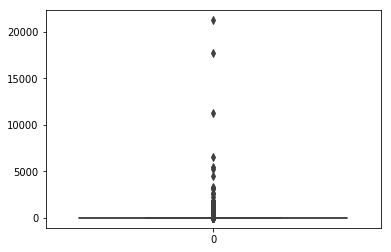

In [145]:
sns.boxplot( data=bikedata_df_appendix['manufacturer_name'].value_counts())

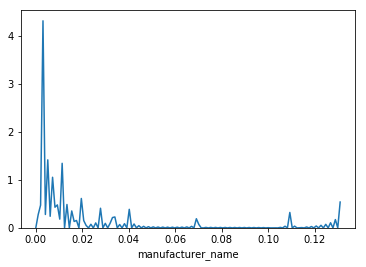

In [146]:
sns.distplot(bikedata_df_appendix['manufacturer_name'].value_counts(sort=True,ascending=False, normalize=True), hist=False)

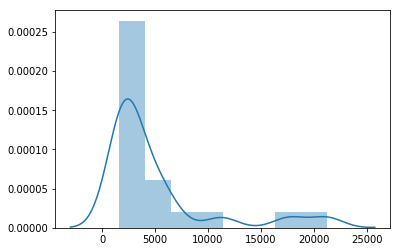

In [147]:
manufacturer_df = pd.DataFrame(data=bikedata_df_appendix['manufacturer_name'].value_counts())
sns.distplot(manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500])

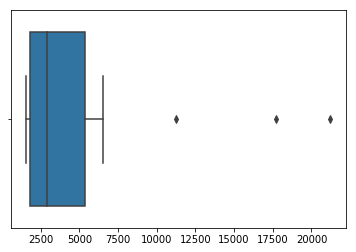

In [148]:
sns.boxplot(manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500])

In [149]:
manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500]

,manufacturer_name
Specialized,21216
Trek,17695
Giant,11260
Cannondale,6510
Schwinn,5466
Fuji,5302
Raleigh,4509
Jamis,3314
Diamondback,3219
Kona,3158


In [150]:
manufacturer_df.loc[manufacturer_df['manufacturer_name']>1500].nunique()

manufacturer_name    20
dtype: int64

In [151]:
# Clean data to anonymize bike brands outside of popular bike brands

bike_brands = ['Specialized','Trek','Giant','Cannondale','Schwinn','Fuji','Raleigh','Jamis','Diamondback', 'Kona','Surly','Bianchi','Marin Bikes','Electra','GT Bicycles','SCOTT','Felt','Novara','KHS Bicycles','Mission Bicycles']
bikedata_df_appendix.loc[~bikedata_df_appendix['manufacturer_name'].isin(bike_brands), 'manufacturer_name'] = 'Other'

In [152]:
bikedata_df_appendix.head(10)

,date_stolen,frame_colors,manufacturer_name,stolen,year_stolen,dhouse,dlivedsf,dincome,dage,movesf_Not at all likely,...,dethnic_Latino/Hispanic,dethnic_Mixed Ethnicity,dethnic_Native American/Indian,dethnic_Other,dethnic_Pacific Islander,dethnic_White/Caucasian,deduc_4 or more years of college/Post Graduate,deduc_High school,deduc_Less than 4 years of college,deduc_Less than high school
0,NaN,['Green'],Trek,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,['Black'],KHS Bicycles,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"['Silver, gray or bare metal']",Kona,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,['Blue'],Trek,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,"['Silver, gray or bare metal']",Trek,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,['Green'],Bianchi,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,['Blue'],Other,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,['Yellow or Gold'],Other,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,['Black'],Other,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,"['White', 'Blue']",Fuji,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
bikedata_df_appendix['manufacturer_name'].value_counts(normalize=True)

Other               0.374741
Specialized         0.130969
Trek                0.109234
Giant               0.069510
Cannondale          0.040187
Schwinn             0.033742
Fuji                0.032730
Raleigh             0.027835
Jamis               0.020458
Diamondback         0.019871
Kona                0.019495
Surly               0.016680
Bianchi             0.015698
Marin Bikes         0.013723
Electra             0.011402
GT Bicycles         0.011297
SCOTT               0.011044
Felt                0.011031
Novara              0.010784
KHS Bicycles        0.010050
Mission Bicycles    0.009519
Name: manufacturer_name, dtype: float64

In [154]:
bikedata_df_appendix['manufacturer_name'].groupby(bikedata_df_appendix['stolen']).value_counts(normalize=True)

stolen  manufacturer_name
False   Other                0.386960
        Specialized          0.132273
        Trek                 0.100156
        Giant                0.069232
        Cannondale           0.035557
        Schwinn              0.033153
        Fuji                 0.032276
        Raleigh              0.027452
        Jamis                0.021016
        Kona                 0.019348
        Diamondback          0.018684
        Surly                0.017711
        Bianchi              0.015126
        Marin Bikes          0.014240
        Electra              0.012358
        Mission Bicycles     0.011813
        KHS Bicycles         0.011220
        Felt                 0.010967
        SCOTT                0.010413
        GT Bicycles          0.010231
        Novara               0.009812
True    Other                0.331231
        Trek                 0.141558
        Specialized          0.126327
        Giant                0.070497
        Cannondale      

**Assumption 8:** Of the 4238 manufacturers in this dataset, I defined a significant manufacturer by a threshold of 1500 bikes registered. Otherwise, I will classify them as "other". There are 20 manufacturers to note in the dataset. These 20 manufacturers represent 62.53% of the total dataset, 61.3% of non-stolen bikes, and 66.88% of stolen bikes.

In [155]:
# Explore the distribution of bike colours and identify the most commonly used colour descriptions
bikedata_df_appendix['frame_colors'].nunique()

802

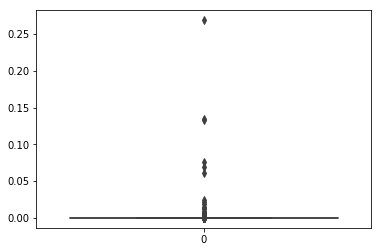

In [156]:
sns.boxplot( data=bikedata_df_appendix['frame_colors'].value_counts(normalize=True))

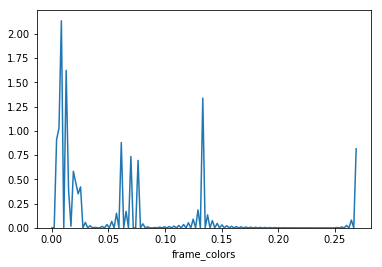

In [157]:
sns.distplot(bikedata_df_appendix['frame_colors'].value_counts(sort=True,ascending=True, normalize=True), hist=False)

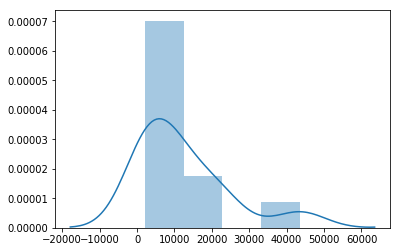

In [158]:
colors_df = pd.DataFrame(data=bikedata_df_appendix['frame_colors'].value_counts())
sns.distplot(colors_df.loc[colors_df['frame_colors']>2000])

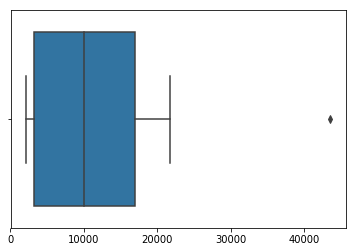

In [159]:
sns.boxplot(colors_df.loc[colors_df['frame_colors']>2000])

In [160]:
colors_df.loc[colors_df['frame_colors']>2000]

,frame_colors
['Black'],43552
"['Silver, gray or bare metal']",21736
['Blue'],21569
['White'],12389
['Red'],11255
['Green'],9973
['Orange'],3957
['Purple'],3503
['Yellow or Gold'],3046
['Teal'],2326


In [161]:
colors_df.loc[colors_df['frame_colors']>2000].count()

frame_colors    11
dtype: int64

In [162]:
#bike_color = ["['Black']","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Orange']","['Purple']","['Yellow or Gold']","['Teal']","['Brown']","['Black', 'Red']","['Pink']","['Black', 'Blue']","['Black', 'Green']"]
bike_color = ["['Black']","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Orange']","['Purple']","['Yellow or Gold']","['Teal']","['Brown']"]
bikedata_df_appendix.loc[~bikedata_df_appendix['frame_colors'].isin(bike_color), 'frame_colors'] = 'Other'

In [163]:
bikedata_df_appendix['frame_colors'].value_counts(normalize=True)

['Black']                         0.268853
Other                             0.163946
['Silver, gray or bare metal']    0.134179
['Blue']                          0.133149
['White']                         0.076479
['Red']                           0.069479
['Green']                         0.061565
['Orange']                        0.024427
['Purple']                        0.021625
['Yellow or Gold']                0.018803
['Teal']                          0.014359
['Brown']                         0.013136
Name: frame_colors, dtype: float64

In [164]:
bikedata_df_appendix['frame_colors'].groupby(bikedata_df_appendix['stolen']).value_counts(normalize=True)

stolen  frame_colors                  
False   ['Black']                         0.274406
        Other                             0.147707
        ['Blue']                          0.138425
        ['Silver, gray or bare metal']    0.135729
        ['White']                         0.075376
        ['Red']                           0.070537
        ['Green']                         0.064211
        ['Orange']                        0.024614
        ['Purple']                        0.022606
        ['Yellow or Gold']                0.018858
        ['Teal']                          0.014367
        ['Brown']                         0.013165
True    ['Black']                         0.249078
        Other                             0.221769
        ['Silver, gray or bare metal']    0.128664
        ['Blue']                          0.114361
        ['White']                         0.080408
        ['Red']                           0.065711
        ['Green']                         0

**Assumption 8:** Of the 802 frame colours in this dataset, I defined a significant frame colour by a threshold of 2000 bikes registered. Otherwise, I will classify them as "Other". There are 12 frame colours to note in the dataset. These 12 frame colours represent 83.61% of the total dataset, 85.23% of non-stolen bikes, and 77.82% of stolen bikes.

In [165]:
bikedata_df_appendix.columns

Index(['date_stolen', 'frame_colors', 'manufacturer_name', 'stolen',
       'year_stolen', 'dhouse', 'dlivedsf', 'dincome', 'dage',
       'movesf_Not at all likely', 'movesf_Not too likely',
       'movesf_Somewhat likely', 'movesf_Very likely', 'gender_Female',
       'gender_Male', 'gender_Other', 'dethnic_Asian or Pacific Islander',
       'dethnic_Black/African American', 'dethnic_Dont know',
       'dethnic_Latino/Hispanic', 'dethnic_Mixed Ethnicity',
       'dethnic_Native American/Indian', 'dethnic_Other',
       'dethnic_Pacific Islander', 'dethnic_White/Caucasian',
       'deduc_4 or more years of college/Post Graduate', 'deduc_High school',
       'deduc_Less than 4 years of college', 'deduc_Less than high school'],
      dtype='object')

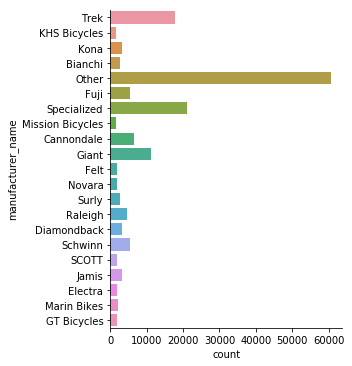

In [166]:
sns.catplot(y="manufacturer_name", kind="count", data=bikedata_df_appendix)

Most common bikes in the dataset are: Specialized, Trek, Giant, Fuji, Schwinn

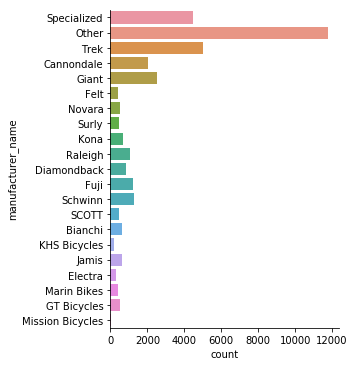

In [167]:
sns.catplot(y="manufacturer_name", kind="count", data=bikedata_df_appendix.loc[bikedata_df_appendix['stolen']==True])

Most common stolen bike brands are: Trek, Specialized, Giant, Cannondale.

Interesting that Cannondale stands out in the stolen data.

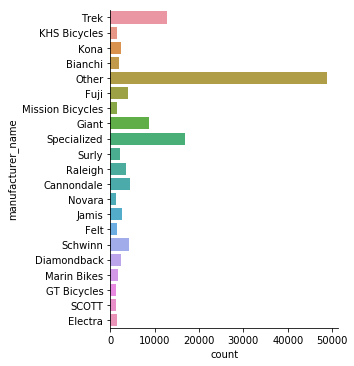

In [168]:
sns.catplot(y="manufacturer_name", kind="count", data=bikedata_df_appendix.loc[bikedata_df_appendix['stolen']==False])

Most common bikes not stolen are: Trek, Specialized, Giant, Raleigh, Cannondale, Schwinn, Fuji.

Although these observations are a bit biased as this reflects moreover bike popularity for purchase rather than likelihood to be stolen.

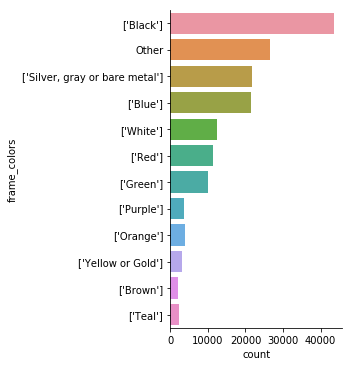

In [169]:
sns.catplot(y='frame_colors', kind='count', data=bikedata_df_appendix,
            order=["['Black']","Other","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Purple']","['Orange']","['Yellow or Gold']","['Brown']","['Teal']"])

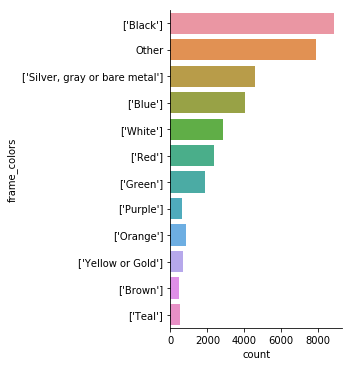

In [170]:
sns.catplot(y='frame_colors', kind='count', data=bikedata_df_appendix.loc[bikedata_df_appendix['stolen']==True],
           order=["['Black']","Other","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Purple']","['Orange']","['Yellow or Gold']","['Brown']","['Teal']"])

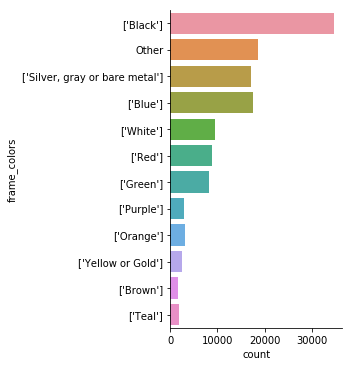

In [171]:
sns.catplot(y='frame_colors', kind='count', data=bikedata_df_appendix.loc[bikedata_df_appendix['stolen']==False],
           order=["['Black']","Other","['Silver, gray or bare metal']","['Blue']","['White']","['Red']","['Green']","['Purple']","['Orange']","['Yellow or Gold']","['Brown']","['Teal']"])

### Looking at stolen bike data alone for relationships

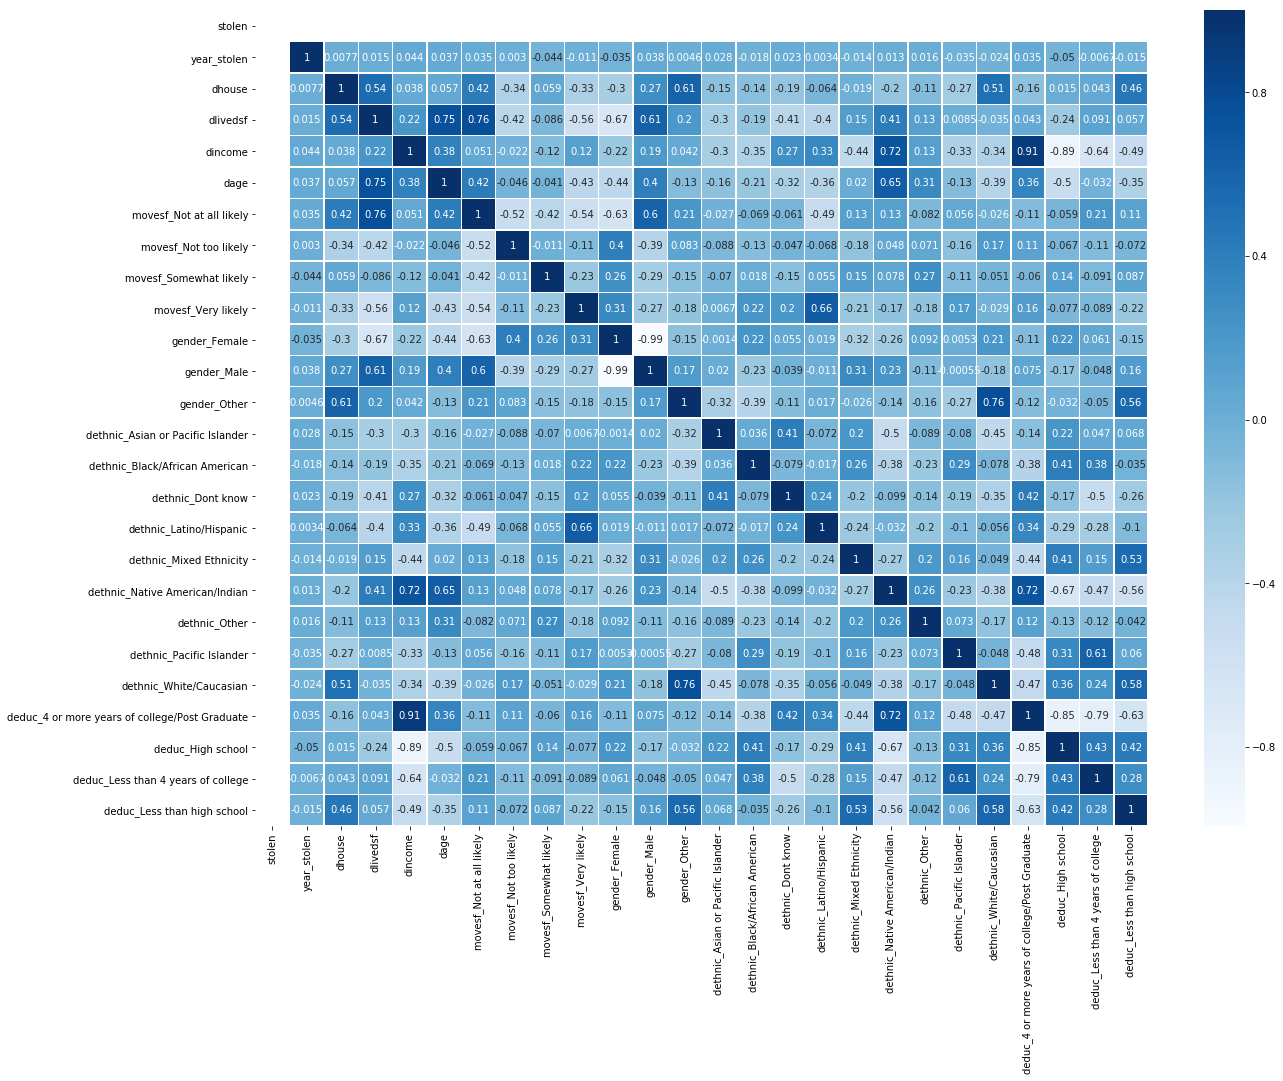

In [172]:
fig, ax = pyplot.subplots(figsize=(20,15))         # Sample figsize in inches

sns.heatmap(bikedata_df_appendix.loc[bikedata_df_appendix['stolen']==True].corr(),ax=ax,annot=True,linewidths=.5,cmap="Blues")

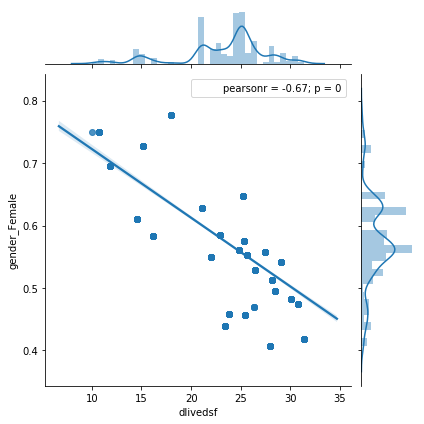

In [173]:
graph = sns.jointplot(y='gender_Female',x='dlivedsf',data=bikedata_df_appendix,kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

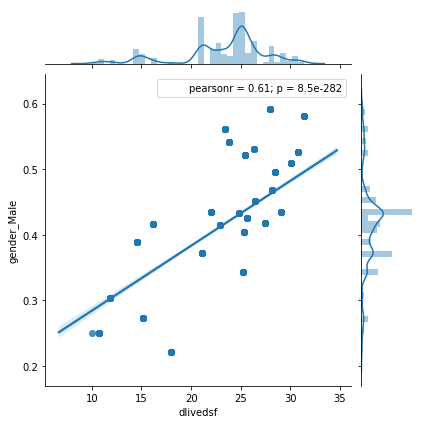

In [174]:
graph = sns.jointplot(y='gender_Male',x='dlivedsf',data=bikedata_df_appendix,kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

If a bike has been stolen, it is less likely that area has more tenured female residents. However, it is more likely that that zipcode has more tenured male residents.

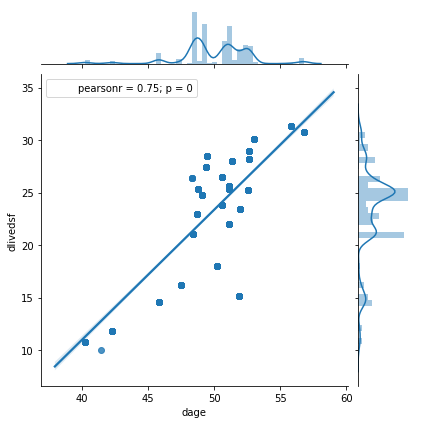

In [175]:
graph = sns.jointplot(y='dlivedsf',x='dage',data=bikedata_df_appendix,kind='reg')
graph.annotate(stats.pearsonr)
pyplot.show()

## Part 3: Technical Notebook

*A detailed Jupyter Notebook with a summary of your analysis, approach, and evaluation metrics.*

Note: Here are some things to consider in your notebook: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, and any relationships between your target and independent variables.

In [176]:
# Import the Machine Learning Libraries

# Data cleaning for machine learning models
from sklearn.model_selection import train_test_split #split data into testing and training data
from sklearn.feature_selection import SelectKBest # identify best X that may predict Y
from sklearn.feature_selection import mutual_info_regression #needed for SelectKBest
from sklearn.preprocessing import StandardScaler #handle outliers after selecting K best guess variables that predict Y

# Machine Learning model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
#reg = LinearRegression(fit_intercept=True)
#fit_intercept = True; hyper parameter for linear regression, add one-extra term - a start value (a starting weight); rarely False



# Error Measures
from sklearn.dummy import DummyRegressor
# Use DummyRegressor to compare your linear regression to the dumbest possible

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [177]:
bikedata_ml=bikedata_df_appendix.copy()

In [178]:
bikedata_ml=pd.get_dummies(bikedata_ml,columns=['stolen','manufacturer_name','frame_colors'])

In [179]:
bikedata_ml.head().T

,0,1,2,3,4
date_stolen,NaN,NaN,NaN,NaN,NaN
year_stolen,NaN,NaN,NaN,NaN,NaN
dhouse,NaN,NaN,NaN,NaN,NaN
dlivedsf,NaN,NaN,NaN,NaN,NaN
dincome,NaN,NaN,NaN,NaN,NaN
dage,NaN,NaN,NaN,NaN,NaN
movesf_Not at all likely,NaN,NaN,NaN,NaN,NaN
movesf_Not too likely,NaN,NaN,NaN,NaN,NaN
movesf_Somewhat likely,NaN,NaN,NaN,NaN,NaN
movesf_Very likely,NaN,NaN,NaN,NaN,NaN


### It was at this point that I realized that I did not have the right data to input into a model with success. Thanks for reading through my appendix! :)

# Learning 2: Use a simple model if things are breaking

In the actual project, I attempted to use some interesting regression models to see if I could predict stolen rate as defined as total stolen bikes divided by total population. I didn't realize that I had some nasty outliers.

# Part 3: Technical Notebook

*A detailed Jupyter Notebook with a summary of your analysis, approach, and evaluation metrics.*

Note: Here are some things to consider in your notebook: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, and any relationships between your target and independent variables.

## Model Information

The models I used are packaged in sklearn.

I started with Linear Regression expecting a poor fit and large error; decision tree overfit, and implemented all these measures against outcomes of the dummy regressor.

Three models not covered in class that I used can be found in the sklearn website:
- [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
    - High Dimensions
    - Score: R^2
- [Ridge Regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
    - Penalty on coefficients
    - L2 Regularization
    - Score: R^2
- [Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso)
    - Prefers solutions with fewer parameter values
    - Reduces # of variables
    - Score: R^2
- [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
    - L1 and L2
    - Weights are nonzero (L1) but there is regularization (L2)
    - Score: R^2

Scoring methods used:
- [r2 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score): Best score = 1.0
- [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error): Best score = 0, error is measured as is
- [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error): Best score = 0, larger error is amplified, smaller errors minimized


In [180]:
# Import the Machine Learning Libraries

# Data cleaning for machine learning models
from sklearn.model_selection import train_test_split #split data into testing and training data
from sklearn.feature_selection import SelectKBest # identify best X that may predict Y
from sklearn.model_selection import KFold #Cross Validation
from sklearn.feature_selection import mutual_info_regression #needed for SelectKBest
from sklearn.preprocessing import StandardScaler #handle outliers after selecting K best guess variables that predict Y
from sklearn.feature_selection import VarianceThreshold


# Machine Learning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression #Linear Regression and Lasso
#reg = LinearRegression(fit_intercept=True)
#fit_intercept = True; hyper parameter for linear regression, add one-extra term - a start value (a starting weight); rarely False
from sklearn import svm #Support Vector Machines
from sklearn import tree # Decision Trees
from sklearn import linear_model #Ridge Regression
from sklearn.linear_model import ElasticNet # Elastic Net

# Error Measures
from sklearn.dummy import DummyRegressor
# Use DummyRegressor to compare your linear regression to the dumbest possible

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Split data into X, y, test, train, validation sets and process

## Test different Models

### Standard Scaler

In [181]:
# Read in the data
bikedata_ml = bikedata_df.copy()

bikedata_ml['stolen_rate']=bikedata_ml['stolen_rate']*500
y=bikedata_ml['stolen_rate']
X=bikedata_ml.drop(columns=['stolen_rate','zipcode','total_stolen'])

# we make our test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

print (X_train.shape, X_val.shape, X_test.shape)

(402, 84) (173, 84) (247, 84)


In [182]:
# Process and standardize data
def feature_preprocess(X, y, ss=None):
    if ss is None:
        ss = StandardScaler()
        ss.fit(X)
        
    X_ss = ss.transform(X)
        
    return X_ss, y, ss

X_test_proc, y_test_proc, ss = feature_preprocess(X_test,y_test,ss=None)
X_train_proc, y_train_proc, ss = feature_preprocess(X_train,y_train,ss=None)
X_val_proc, y_val_proc, ss = feature_preprocess(X_val,y_val,ss=None)

In [183]:
models = []
models.append(('reg',LinearRegression(fit_intercept=True),'Linear Regression'))
models.append(('decision_tree', tree.DecisionTreeRegressor(),'Decision Trees'))
models.append(('supvm', svm.SVR(),'Support Vector Machines'))
models.append(('ridge',linear_model.Ridge(alpha=.5),'Ridge Regression'))
models.append(('lasso',linear_model.Lasso(alpha=0.1),'Lasso'))
models.append(('elastic_net',linear_model.ElasticNet(alpha=1.0, l1_ratio=1.0, fit_intercept=True, normalize=False, random_state=0),'Elastic Net'))


for name, model, common_name in models:
    name = model
    name.fit(X_train_proc, y_train_proc)
    
    print(common_name, 'train score:',name.score(X_train_proc,y_train_proc))
    print(common_name, 'validation score:',name.score(X_val_proc, y_val_proc))
    print(common_name, 'test score:',name.score(X_test_proc, y_test_proc),'\n')
    
    print(common_name, 'train r^2 score:',r2_score(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation r^2 score:',r2_score(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean r^2 score:',r2_score(name.predict(X_test_proc), y_test_proc),'\n')

    print(common_name, 'train mean absolute error:',mean_absolute_error(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation mean absolute error:',mean_absolute_error(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean absolute error:',mean_absolute_error(name.predict(X_test_proc), y_test_proc),'\n')
   
    print(common_name, 'train mean squared error:',mean_squared_error(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation mean squared error:',mean_squared_error(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean squared error:',mean_squared_error(name.predict(X_test_proc), y_test_proc),'\n')
    
    dummy_preds = DummyRegressor().fit(X_train_proc, y_train_proc).predict(X_val_proc)

    print(common_name, 'dummy r^2 score:',r2_score(dummy_preds, y_val_proc))
    print(common_name, 'dummy mean absolute error:',mean_absolute_error(dummy_preds, y_val_proc))
    print(common_name, 'dummy mean squared error:',mean_squared_error(dummy_preds, y_val_proc),'\n','-----','\n')

    

Linear Regression train score: 0.5780128039207761
Linear Regression validation score: -0.2075567824428486
Linear Regression test score: -1.1396598340891546e+17 

Linear Regression train r^2 score: 0.27687672167153865
Linear Regression validation r^2 score: -4.018854043054898
Linear Regression test mean r^2 score: 2.4278346000272677e-10 

Linear Regression train mean absolute error: 0.17874590716128966
Linear Regression validation mean absolute error: 1.1978967873448294
Linear Regression test mean absolute error: 67970684.58885892 

Linear Regression train mean squared error: 0.08328298742547394
Linear Regression validation mean squared error: 8.383477156249775
Linear Regression test mean squared error: 1.8145858351413146e+17 

Linear Regression dummy r^2 score: -9.123505469456647e+33
Linear Regression dummy mean absolute error: 0.532849425425967
Linear Regression dummy mean squared error: 7.028492952562913 
 ----- 

Decision Trees train score: 0.9999999772234386
Decision Trees validati

### Feature Selection: Variance Thresholding

In [184]:
# Reset the variables by reading in the data
bikedata_ml = bikedata_df.copy()

bikedata_ml['stolen_rate']=bikedata_ml['stolen_rate']*500
y=bikedata_ml['stolen_rate']
X=bikedata_ml.drop(columns=['stolen_rate','zipcode','total_population','total_stolen'])

# Apply Variance Threshold
print('X before Variance thresholding: ',X.shape,'\n')
vt = VarianceThreshold(threshold=0.05)
X = vt.fit_transform(X)
print('X after Variance thresholding: ',X.shape,'\n')

# we make our test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

print ('X_train shape:',X_train.shape,'\n','X_val shape:', X_val.shape,'\n','X_test shape:', X_test.shape)

X before Variance thresholding:  (822, 83) 

X after Variance thresholding:  (822, 76) 

X_train shape: (402, 76) 
 X_val shape: (173, 76) 
 X_test shape: (247, 76)


In [185]:
# Process and standardize data
def feature_preprocess(X, y, ss=None):
    if ss is None:
        ss = StandardScaler()
        ss.fit(X)

    X_ss = ss.transform(X)
        
    return X_ss, y, ss

X_test_proc, y_test_proc, ss = feature_preprocess(X_test,y_test,ss=None)
X_train_proc, y_train_proc, ss = feature_preprocess(X_train,y_train,ss=None)
X_val_proc, y_val_proc, ss = feature_preprocess(X_val,y_val,ss=None)

In [186]:
models = []
models.append(('reg',LinearRegression(fit_intercept=True),'Linear Regression'))
models.append(('decision_tree', tree.DecisionTreeRegressor(),'Decision Trees'))
models.append(('supvm', svm.SVR(),'Support Vector Machines'))
models.append(('ridge',linear_model.Ridge(alpha=.5),'Ridge Regression'))
models.append(('lasso',linear_model.Lasso(alpha=0.1),'Lasso'))
models.append(('elastic_net',linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, random_state=0),'Elastic Net'))


for name, model, common_name in models:
    name = model
    name.fit(X_train_proc, y_train_proc)
    
    print(common_name, 'train score:',name.score(X_train_proc,y_train_proc))
    print(common_name, 'validation score:',name.score(X_val_proc, y_val_proc))
    print(common_name, 'test score:',name.score(X_test_proc, y_test_proc),'\n')
    
    print(common_name, 'train r^2 score:',r2_score(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation r^2 score:',r2_score(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean r^2 score:',r2_score(name.predict(X_test_proc), y_test_proc),'\n')

    print(common_name, 'train mean absolute error:',mean_absolute_error(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation mean absolute error:',mean_absolute_error(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean absolute error:',mean_absolute_error(name.predict(X_test_proc), y_test_proc),'\n')
   
    print(common_name, 'train mean squared error:',mean_squared_error(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation mean squared error:',mean_squared_error(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean squared error:',mean_squared_error(name.predict(X_test_proc), y_test_proc),'\n')
    
    dummy_preds = DummyRegressor().fit(X_train_proc, y_train_proc).predict(X_val_proc)

    print(common_name, 'dummy r^2 score:',r2_score(dummy_preds, y_val_proc))
    print(common_name, 'dummy mean absolute error:',mean_absolute_error(dummy_preds, y_val_proc))
    print(common_name, 'dummy mean squared error:',mean_squared_error(dummy_preds, y_val_proc),'\n','-----','\n')

    

Linear Regression train score: 0.7994487638277691
Linear Regression validation score: -6.861363915236041e+17
Linear Regression test score: -6.722370675202975 

Linear Regression train r^2 score: 0.7490200304770708
Linear Regression validation r^2 score: -2.5393220859371013e-10
Linear Regression test mean r^2 score: -0.0457297960132792 

Linear Regression train mean absolute error: 0.561208555099503
Linear Regression validation mean absolute error: 220100285.59192088
Linear Regression test mean absolute error: 1.7049802710172277 

Linear Regression train mean squared error: 0.6653465184779414
Linear Regression validation mean squared error: 5.28791867958048e+17
Linear Regression test mean squared error: 6.714519893323723 

Linear Regression dummy r^2 score: -2.8201786600752633e+31
Linear Regression dummy mean absolute error: 0.3899837258569147
Linear Regression dummy mean squared error: 0.7821311803143582 
 ----- 

Decision Trees train score: 0.9999999985496258
Decision Trees validation

### Feature Selection: SelectKBest

In [187]:
# Reset the variables by reading in the data
bikedata_ml = bikedata_df.copy()

bikedata_ml['stolen_rate']=bikedata_ml['stolen_rate']*500
y=bikedata_ml['stolen_rate']
X=bikedata_ml.drop(columns=['stolen_rate','zipcode','total_population','total_stolen'])

# we make our test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

print ('X_train shape:',X_train.shape,'\n','X_val shape:', X_val.shape,'\n','X_test shape:', X_test.shape)

X_train shape: (402, 83) 
 X_val shape: (173, 83) 
 X_test shape: (247, 83)


In [188]:
# Process and standardize data

print('X before Select K Best: ',X_val_proc.shape,'\n')

def feature_preprocess(X, y, ss=None, skb=None):
    if ss is None:
        ss = StandardScaler()
        ss.fit(X)

    X_ss = ss.transform(X)
    
    if skb is None:
        skb = SelectKBest(mutual_info_regression, k=4)
        skb.fit(X_ss, y)
        
    X = skb.transform(X_ss)
        
    return X, y, ss, skb

X_test_proc, y_test_proc, ss, skb = feature_preprocess(X_test,y_test,ss=None,skb=None)
X_train_proc, y_train_proc, ss, skb = feature_preprocess(X_train,y_train,ss=None,skb=None)
X_val_proc, y_val_proc, ss, skb = feature_preprocess(X_val,y_val,ss=None,skb=None)
print('X after Select K Best: ',X_val_proc.shape,'\n')

X_train.columns[skb.get_support()]

X before Select K Best:  (173, 76) 

X after Select K Best:  (173, 4) 



Index(['Percent; SEX AND AGE - 10 to 14 years',
       'Percent; SEX AND AGE - 25 to 34 years',
       'Percent; SEX AND AGE - 18 years and over',
       'Percent; SEX AND AGE - 21 years and over'],
      dtype='object')

In [189]:
models = []
models.append(('reg',LinearRegression(fit_intercept=True),'Linear Regression'))
models.append(('decision_tree', tree.DecisionTreeRegressor(),'Decision Trees'))
models.append(('supvm', svm.SVR(),'Support Vector Machines'))
models.append(('ridge',linear_model.Ridge(alpha=.5),'Ridge Regression'))
models.append(('lasso',linear_model.Lasso(alpha=0.1),'Lasso'))
models.append(('elastic_net',linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, random_state=0),'Elastic Net'))


for name, model, common_name in models:
    name = model
    name.fit(X_train_proc, y_train_proc)
    
    print(common_name, 'train score:',name.score(X_train_proc,y_train_proc))
    print(common_name, 'validation score:',name.score(X_val_proc, y_val_proc))
    print(common_name, 'test score:',name.score(X_test_proc, y_test_proc),'\n')
    
    print(common_name, 'train r^2 score:',r2_score(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation r^2 score:',r2_score(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean r^2 score:',r2_score(name.predict(X_test_proc), y_test_proc),'\n')

    print(common_name, 'train mean absolute error:',mean_absolute_error(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation mean absolute error:',mean_absolute_error(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean absolute error:',mean_absolute_error(name.predict(X_test_proc), y_test_proc),'\n')
   
    print(common_name, 'train mean squared error:',mean_squared_error(name.predict(X_train_proc), y_train_proc))
    print(common_name, 'validation mean squared error:',mean_squared_error(name.predict(X_val_proc), y_val_proc))
    print(common_name, 'test mean squared error:',mean_squared_error(name.predict(X_test_proc), y_test_proc),'\n')
    
    dummy_preds = DummyRegressor().fit(X_train_proc, y_train_proc).predict(X_val_proc)

    print(common_name, 'dummy r^2 score:',r2_score(dummy_preds, y_val_proc))
    print(common_name, 'dummy mean absolute error:',mean_absolute_error(dummy_preds, y_val_proc))
    print(common_name, 'dummy mean squared error:',mean_squared_error(dummy_preds, y_val_proc),'\n','-----','\n')

    

Linear Regression train score: 0.2574962273255057
Linear Regression validation score: 0.18539724574179006
Linear Regression test score: -0.02724449380386451 

Linear Regression train r^2 score: -1.8835520441854152
Linear Regression validation r^2 score: -1.1010788378582008
Linear Regression test mean r^2 score: -177.80177060338144 

Linear Regression train mean absolute error: 0.3890486301777981
Linear Regression validation mean absolute error: 0.5599263804933483
Linear Regression test mean absolute error: 0.4210312758762142 

Linear Regression train mean squared error: 0.8322979417465858
Linear Regression validation mean squared error: 0.9455523346944976
Linear Regression test mean squared error: 4.297535659735025 

Linear Regression dummy r^2 score: 0.0
Linear Regression dummy mean absolute error: 0.42370098493509395
Linear Regression dummy mean squared error: 1.1607619316716091 
 ----- 

Decision Trees train score: 0.9999999978977847
Decision Trees validation score: -0.2943538902112